# CLuster de DIA

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor, plot_importance
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import pickle
from sklearn import metrics



In [2]:
usecols = ['game_id', 'user_id', 'bet_id', 'game_type', 'odds', 'fiat_bet_amount',
       'fiat_profit_amount','fiat_is_valuable']


bets_dtypes = {
    'game_id': 'uint32',
    'user_id': 'uint32',
    'bet_id': 'uint64',
    'game_type': 'category',
    'odds': 'float32',
    'fiat_is_valuable': 'category',
    'fiat_bet_amount': 'float32',
    'fiat_profit_amount': 'float32',
}

bets = pd.read_csv("data/bets.csv", usecols=usecols, dtype=bets_dtypes)
bets = bets[bets['fiat_is_valuable'] == 't']


In [3]:
bets.head()


game_id  user_id     bet_id game_type  odds fiat_is_valuable  \
0  2828375   173570  210854317    normal   0.0                t   
2  2828375  1139219  210854260    normal   2.0                t   
3  2828375  1329183   12148544    yellow   0.0                t   
4  2828375  1378328  210854292    normal   0.0                t   
5  2828375  1420292  210854342    normal   3.0                t   

   fiat_bet_amount  fiat_profit_amount  
0         0.048738           -0.048738  
2         0.000088            0.000088  
3         0.188109           -0.188109  
4         0.000005           -0.000005  
5         0.000107            0.000213

In [4]:
games_usecols = ['game_id', 'max_rate', 'timestamp'] # ,'bet_count']

games_dtypes = {
    'game_id': 'uint32',
    'max_rate': 'float32',
    'timestamp': 'uint32',
    # 'bet_count': 'uint32',
}

games = pd.read_csv("data/games.csv", usecols=games_usecols, dtype=games_dtypes)


In [5]:

games.head()


game_id   max_rate   timestamp
0  2828375   6.430000  1599622213
1  2828376   2.100000  1599622213
2  2828377   3.110000  1599622213
3  2828378  24.969999  1599622213
4  2828379   1.040000  1599622213

In [6]:
df = pd.merge(bets, games, on='game_id', how='left')
# liberar memória



In [7]:
del bets, games
gc.collect()


0

In [8]:
df.sort_values(['user_id','game_id'], kind='stable', inplace=True, ignore_index=True)



In [9]:
df.head()


game_id  user_id     bet_id game_type  odds fiat_is_valuable  \
0  2831698       44  212042687    normal  1.03                t   
1  2831768       44  212067364    normal  1.03                t   
2  2831820       44  212085405    normal  1.08                t   
3  2832628       44  212376980    normal  1.67                t   
4  2832686       44  212397916    normal  2.00                t   

   fiat_bet_amount  fiat_profit_amount    max_rate   timestamp  
0         0.000034            0.000001    2.370000  1599624003  
1         0.000034            0.000001    2.070000  1599624003  
2         0.000034            0.000003    1.150000  1599624003  
3         0.000035            0.000024    2.060000  1599710467  
4         0.000140            0.000140  328.890015  1599710467

In [10]:
df.columns


Index(['game_id', 'user_id', 'bet_id', 'game_type', 'odds', 'fiat_is_valuable',
       'fiat_bet_amount', 'fiat_profit_amount', 'max_rate', 'timestamp'],
      dtype='object')

In [11]:
df = df.drop(columns=['fiat_is_valuable'])


In [12]:
df.head(20)


game_id  user_id     bet_id game_type  odds  fiat_bet_amount  \
0   2831698       44  212042687    normal  1.03         0.000034   
1   2831768       44  212067364    normal  1.03         0.000034   
2   2831820       44  212085405    normal  1.08         0.000034   
3   2832628       44  212376980    normal  1.67         0.000035   
4   2832686       44  212397916    normal  2.00         0.000140   
5   2832689       44  212399028    normal  0.00         0.000140   
6   2832690       44  212399332    normal  2.00         0.000281   
7   2832691       44  212399705    normal  2.00         0.000140   
8   2837444       44  214069523    normal  1.03         0.000037   
9   2843418       44  216156160    normal  1.02         0.000039   
10  2843797       44  216305425    normal  1.08         0.000039   
11  2843800       44  216306551    normal  1.02         0.000155   
12  2844658       44  216602839    normal  1.03         0.000039   
13  2851773       44  219109074    normal  1.06         0.000038   
14  2851775       44  219109971    normal  1.05         0.000038   
15  2851776       44  219110308    normal  1.40         0.000038   
16  2851777       44  219110641    normal  1.06         0.000038   
17  2851779       44  219111184    normal  1.02         0.000038   
18  2851780       44  219111708    normal  1.16         0.000038   
19  2851781       44  219112030    normal  1.07         0.000038   

    fiat_profit_amount    max_rate   timestamp  
0         1.013535e-06    2.370000  1599624003  
1         1.013535e-06    2.070000  1599624003  
2         2.702760e-06    1.150000  1599624003  
3         2.353256e-05    2.060000  1599710467  
4         1.404929e-04  328.890015  1599710467  
5        -1.404929e-04    1.100000  1599710467  
6         2.809858e-04    2.950000  1599710467  
7         1.404929e-04    7.670000  1599710467  
8         1.102917e-06    3.310000  1599796823  
9         7.754470e-07    4.460000  1599969622  
10        3.101788e-06    6.430000  1599969622  
11        3.101788e-06    1.370000  1599969622  
12        1.163171e-06    2.270000  1599969622  
13        2.258367e-06    1.630000  1600142423  
14        1.881973e-06    1.250000  1600142423  
15        1.505578e-05    1.510000  1600142423  
16        2.258367e-06    9.070000  1600142423  
17        7.527891e-07    1.520000  1600142423  
18        6.022313e-06    5.150000  1600142423  
19        2.634762e-06    1.250000  1600142423

In [13]:
conditions = [
    (df['game_type'] == 'normal') & (df['odds'] == 0),
    (df['game_type'] == 'green'),
    (df['game_type'] == 'red'),
    (df['game_type'] == 'yellow')
]

values = [
    df['max_rate'],
    2,
    1.96,
    10
]

df['odds_adjusted'] = np.select(conditions, values, default=df['odds'])


In [14]:
df.head()


game_id  user_id     bet_id game_type  odds  fiat_bet_amount  \
0  2831698       44  212042687    normal  1.03         0.000034   
1  2831768       44  212067364    normal  1.03         0.000034   
2  2831820       44  212085405    normal  1.08         0.000034   
3  2832628       44  212376980    normal  1.67         0.000035   
4  2832686       44  212397916    normal  2.00         0.000140   

   fiat_profit_amount    max_rate   timestamp  odds_adjusted  
0            0.000001    2.370000  1599624003           1.03  
1            0.000001    2.070000  1599624003           1.03  
2            0.000003    1.150000  1599624003           1.08  
3            0.000024    2.060000  1599710467           1.67  
4            0.000140  328.890015  1599710467           2.00

In [15]:
past_bets = df.groupby("user_id")["fiat_bet_amount"].shift(1)

df["user_bet_mean_weighted"] = (
    past_bets
    .groupby(df["user_id"])
    .transform(lambda s: s.ewm(alpha=0.01, adjust=False).mean())
)
df["user_bet_mean_weighted"] = df["user_bet_mean_weighted"].fillna(
    df.groupby("user_id")["fiat_bet_amount"].transform("first")
)

df["bet_proportion_weighted"] = df["fiat_bet_amount"] / df["user_bet_mean_weighted"]


In [16]:
df.head(10)


game_id  user_id     bet_id game_type  odds  fiat_bet_amount  \
0  2831698       44  212042687    normal  1.03         0.000034   
1  2831768       44  212067364    normal  1.03         0.000034   
2  2831820       44  212085405    normal  1.08         0.000034   
3  2832628       44  212376980    normal  1.67         0.000035   
4  2832686       44  212397916    normal  2.00         0.000140   
5  2832689       44  212399028    normal  0.00         0.000140   
6  2832690       44  212399332    normal  2.00         0.000281   
7  2832691       44  212399705    normal  2.00         0.000140   
8  2837444       44  214069523    normal  1.03         0.000037   
9  2843418       44  216156160    normal  1.02         0.000039   

   fiat_profit_amount    max_rate   timestamp  odds_adjusted  \
0        1.013535e-06    2.370000  1599624003           1.03   
1        1.013535e-06    2.070000  1599624003           1.03   
2        2.702760e-06    1.150000  1599624003           1.08   
3        2.353256e-05    2.060000  1599710467           1.67   
4        1.404929e-04  328.890015  1599710467           2.00   
5       -1.404929e-04    1.100000  1599710467           1.10   
6        2.809858e-04    2.950000  1599710467           2.00   
7        1.404929e-04    7.670000  1599710467           2.00   
8        1.102917e-06    3.310000  1599796823           1.03   
9        7.754470e-07    4.460000  1599969622           1.02   

   user_bet_mean_weighted  bet_proportion_weighted  
0                0.000034                 1.000000  
1                0.000034                 1.000000  
2                0.000034                 1.000000  
3                0.000034                 1.039625  
4                0.000034                 4.156854  
5                0.000035                 4.029644  
6                0.000036                 7.822300  
7                0.000038                 3.661361  
8                0.000039                 0.933260  
9                0.000039                 0.984903

In [17]:
gamma = 0.6
delta = 0.4
raw = gamma * np.log(df["odds_adjusted"]) + delta * np.log(df["bet_proportion_weighted"])

mu = raw.mean()
sd = raw.std() + 1e-12
df["risk"] = (raw - mu) / sd 





In [18]:

df.head(100)


game_id  user_id     bet_id game_type  odds  fiat_bet_amount  \
0   2831698       44  212042687    normal  1.03         0.000034   
1   2831768       44  212067364    normal  1.03         0.000034   
2   2831820       44  212085405    normal  1.08         0.000034   
3   2832628       44  212376980    normal  1.67         0.000035   
4   2832686       44  212397916    normal  2.00         0.000140   
..      ...      ...        ...       ...   ...              ...   
95  2828664     5588   12159782    yellow  0.00         7.090167   
96  2828665     5588   12159820       red  0.00         1.772542   
97  2828665     5588   12159822     green  2.00         0.886271   
98  2828666     5588   12159859     green  2.00         7.090167   
99  2828666     5588   12159862       red  0.00         3.545083   

    fiat_profit_amount    max_rate   timestamp  odds_adjusted  \
0             0.000001    2.370000  1599624003           1.03   
1             0.000001    2.070000  1599624003           1.03   
2             0.000003    1.150000  1599624003           1.08   
3             0.000024    2.060000  1599710467           1.67   
4             0.000140  328.890015  1599710467           2.00   
..                 ...         ...         ...            ...   
95           -7.090167    2.410000  1599624003          10.00   
96           -1.772542    7.400000  1599624003           1.96   
97            0.886271    7.400000  1599624003           2.00   
98            7.090167    3.030000  1599624003           2.00   
99           -3.545083    3.030000  1599624003           1.96   

    user_bet_mean_weighted  bet_proportion_weighted      risk  
0                 0.000034                 1.000000  0.302424  
1                 0.000034                 1.000000  0.302424  
2                 0.000034                 1.000000  0.325404  
3                 0.000034                 1.039625  0.549258  
4                 0.000034                 4.156854  1.084575  
..                     ...                      ...       ...  
95                4.320677                 1.640985  1.564405  
96                4.348371                 0.407633  0.324301  
97                4.322613                 0.205031  0.112001  
98                4.288250                 1.653394  0.786622  
99                4.316269                 0.821330  0.550710  

[100 rows x 13 columns]

In [19]:
def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
    float_cols = df.select_dtypes(include=['float64','float32']).columns
    df[float_cols] = df[float_cols].astype('float32', copy=False)

    int_cols = df.select_dtypes(include=['int64','int32','int']).columns
    for c in int_cols:
        if df[c].min() >= 0 and df[c].max() <= np.iinfo(np.uint32).max:
            df[c] = df[c].astype('uint32', copy=False)
        else:
            df[c] = df[c].astype('int32', copy=False)


    if 'user_id' in df.columns:
        df['user_id'] = df['user_id'].astype('category')


    if 'game_id' in df.columns:
        df['game_id'] = df['game_id'].astype('category')

    gc.collect()
    return df


In [20]:
df = downcast_df(df)


In [21]:
# df = df.drop(columns=['game_type','odds','max_rate','odds_adjusted','bet_proportion_weighted','user_bet_mean_weighted'])
df = df.drop(columns=['game_type','odds','max_rate','bet_proportion_weighted','user_bet_mean_weighted'])
df.head()


game_id user_id     bet_id  fiat_bet_amount  fiat_profit_amount  \
0  2831698      44  212042687         0.000034            0.000001   
1  2831768      44  212067364         0.000034            0.000001   
2  2831820      44  212085405         0.000034            0.000003   
3  2832628      44  212376980         0.000035            0.000024   
4  2832686      44  212397916         0.000140            0.000140   

    timestamp  odds_adjusted      risk  
0  1599624003           1.03  0.302424  
1  1599624003           1.03  0.302424  
2  1599624003           1.08  0.325404  
3  1599710467           1.67  0.549258  
4  1599710467           2.00  1.084575

In [22]:
g = (df.groupby('game_id', observed=True)
       .agg(
        #   risk_mean_game   = ('risk', 'mean'),
        #   risk_std_game    = ('risk', 'std'),
          risk_median_game = ('risk', 'median'),
          risk_mad_game    = ('risk', lambda s: (s - s.median()).abs().median()),
       #    n_bets_game      = ('risk', 'size'),
       )
       .astype('float32'))

df = df.join(g, on='game_id')


In [23]:
df.head()


game_id user_id     bet_id  fiat_bet_amount  fiat_profit_amount  \
0  2831698      44  212042687         0.000034            0.000001   
1  2831768      44  212067364         0.000034            0.000001   
2  2831820      44  212085405         0.000034            0.000003   
3  2832628      44  212376980         0.000035            0.000024   
4  2832686      44  212397916         0.000140            0.000140   

    timestamp  odds_adjusted      risk  risk_median_game  risk_mad_game  
0  1599624003           1.03  0.302424          0.694806       0.392382  
1  1599624003           1.03  0.302424          0.187841       0.360300  
2  1599624003           1.08  0.325404          0.434880       0.271430  
3  1599710467           1.67  0.549258          0.347304       0.274076  
4  1599710467           2.00  1.084575          0.200435       0.306508

In [24]:
# df.drop(columns=['risk_mean_game','risk_std_game','risk_rel_game_z','risk_rel_game_mad','risk_median_game', 'risk_mad_game'], inplace=True)



In [25]:
# df["risk_rel_game_z"] = (df["risk"] - df["risk_mean_game"]) / (df["risk_std_game"] + 1e-12)
df["risk_mad"] = (df["risk"] - df["risk_median_game"]) / 1.4826 * df["risk_mad_game"] + 1e-12


In [26]:
df.head(100)


game_id user_id     bet_id  fiat_bet_amount  fiat_profit_amount  \
0   2831698      44  212042687         0.000034            0.000001   
1   2831768      44  212067364         0.000034            0.000001   
2   2831820      44  212085405         0.000034            0.000003   
3   2832628      44  212376980         0.000035            0.000024   
4   2832686      44  212397916         0.000140            0.000140   
..      ...     ...        ...              ...                 ...   
95  2828664    5588   12159782         7.090167           -7.090167   
96  2828665    5588   12159820         1.772542           -1.772542   
97  2828665    5588   12159822         0.886271            0.886271   
98  2828666    5588   12159859         7.090167            7.090167   
99  2828666    5588   12159862         3.545083           -3.545083   

     timestamp  odds_adjusted      risk  risk_median_game  risk_mad_game  \
0   1599624003           1.03  0.302424          0.694806       0.392382   
1   1599624003           1.03  0.302424          0.187841       0.360300   
2   1599624003           1.08  0.325404          0.434880       0.271430   
3   1599710467           1.67  0.549258          0.347304       0.274076   
4   1599710467           2.00  1.084575          0.200435       0.306508   
..         ...            ...       ...               ...            ...   
95  1599624003          10.00  1.564405          0.053775       0.308013   
96  1599624003           1.96  0.324301          0.093244       0.292337   
97  1599624003           2.00  0.112001          0.093244       0.292337   
98  1599624003           2.00  0.786623          0.063461       0.304121   
99  1599624003           1.96  0.550710          0.063461       0.304121   

    risk_mad  
0  -0.103847  
1   0.027846  
2  -0.020043  
3   0.037334  
4   0.182784  
..       ...  
95  0.313837  
96  0.045559  
97  0.003698  
98  0.148340  
99  0.099948  

[100 rows x 11 columns]

In [27]:
df.columns


Index(['game_id', 'user_id', 'bet_id', 'fiat_bet_amount', 'fiat_profit_amount',
       'timestamp', 'odds_adjusted', 'risk', 'risk_median_game',
       'risk_mad_game', 'risk_mad'],
      dtype='object')

In [28]:
df.drop(columns=['risk_median_game', 'risk_mad_game'], inplace=True)


In [29]:
df.head(10)


game_id user_id     bet_id  fiat_bet_amount  fiat_profit_amount  \
0  2831698      44  212042687         0.000034        1.013535e-06   
1  2831768      44  212067364         0.000034        1.013535e-06   
2  2831820      44  212085405         0.000034        2.702760e-06   
3  2832628      44  212376980         0.000035        2.353256e-05   
4  2832686      44  212397916         0.000140        1.404929e-04   
5  2832689      44  212399028         0.000140       -1.404929e-04   
6  2832690      44  212399332         0.000281        2.809858e-04   
7  2832691      44  212399705         0.000140        1.404929e-04   
8  2837444      44  214069523         0.000037        1.102917e-06   
9  2843418      44  216156160         0.000039        7.754470e-07   

    timestamp  odds_adjusted      risk  risk_mad  
0  1599624003           1.03  0.302424 -0.103847  
1  1599624003           1.03  0.302424  0.027846  
2  1599624003           1.08  0.325404 -0.020043  
3  1599710467           1.67  0.549258  0.037334  
4  1599710467           2.00  1.084575  0.182784  
5  1599710467           1.10  0.784713  0.151514  
6  1599710467           2.00  1.288898  0.151574  
7  1599710467           2.00  1.043555  0.143360  
8  1599796823           1.03  0.280101 -0.014004  
9  1599969622           1.02  0.292778  0.031583

In [30]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.sort_values(['user_id', 'datetime'])
df = df.set_index('datetime')


In [31]:
df.head()


game_id user_id     bet_id  fiat_bet_amount  \
datetime                                                           
2020-09-09 04:00:03  2831698      44  212042687         0.000034   
2020-09-09 04:00:03  2831768      44  212067364         0.000034   
2020-09-09 04:00:03  2831820      44  212085405         0.000034   
2020-09-10 04:01:07  2832628      44  212376980         0.000035   
2020-09-10 04:01:07  2832686      44  212397916         0.000140   

                     fiat_profit_amount   timestamp  odds_adjusted      risk  \
datetime                                                                       
2020-09-09 04:00:03            0.000001  1599624003           1.03  0.302424   
2020-09-09 04:00:03            0.000001  1599624003           1.03  0.302424   
2020-09-09 04:00:03            0.000003  1599624003           1.08  0.325404   
2020-09-10 04:01:07            0.000024  1599710467           1.67  0.549258   
2020-09-10 04:01:07            0.000140  1599710467           2.00  1.084575   

                     risk_mad  
datetime                       
2020-09-09 04:00:03 -0.103847  
2020-09-09 04:00:03  0.027846  
2020-09-09 04:00:03 -0.020043  
2020-09-10 04:01:07  0.037334  
2020-09-10 04:01:07  0.182784

In [32]:
df["bet_risk"] = 1 / (1 + np.exp(-df["risk"]))
df["bet_risk_mad"] = 1 / (1 + np.exp(-df["risk_mad"]))


In [33]:
df.head()


game_id user_id     bet_id  fiat_bet_amount  \
datetime                                                           
2020-09-09 04:00:03  2831698      44  212042687         0.000034   
2020-09-09 04:00:03  2831768      44  212067364         0.000034   
2020-09-09 04:00:03  2831820      44  212085405         0.000034   
2020-09-10 04:01:07  2832628      44  212376980         0.000035   
2020-09-10 04:01:07  2832686      44  212397916         0.000140   

                     fiat_profit_amount   timestamp  odds_adjusted      risk  \
datetime                                                                       
2020-09-09 04:00:03            0.000001  1599624003           1.03  0.302424   
2020-09-09 04:00:03            0.000001  1599624003           1.03  0.302424   
2020-09-09 04:00:03            0.000003  1599624003           1.08  0.325404   
2020-09-10 04:01:07            0.000024  1599710467           1.67  0.549258   
2020-09-10 04:01:07            0.000140  1599710467           2.00  1.084575   

                     risk_mad  bet_risk  bet_risk_mad  
datetime                                               
2020-09-09 04:00:03 -0.103847  0.575035      0.474062  
2020-09-09 04:00:03  0.027846  0.575035      0.506961  
2020-09-09 04:00:03 -0.020043  0.580641      0.494990  
2020-09-10 04:01:07  0.037334  0.633963      0.509332  
2020-09-10 04:01:07  0.182784  0.747359      0.545569

In [34]:
df.drop(columns=['risk', 'risk_mad'], inplace=True)


In [35]:
df = downcast_df(df)


In [36]:
df.columns


Index(['game_id', 'user_id', 'bet_id', 'fiat_bet_amount', 'fiat_profit_amount',
       'timestamp', 'odds_adjusted', 'bet_risk', 'bet_risk_mad'],
      dtype='object')

In [37]:
df['date'] = df.index.normalize()

daily = (df
    .groupby(['user_id','date'], observed=True)
    .agg(
        risk_mean   = ('bet_risk', 'mean'),
        risk_median = ('bet_risk', 'median'),
        risk_std    = ('bet_risk', 'std'),
        risk_max = ('bet_risk', 'max'),
        risk_p95 = ('bet_risk', lambda s: s.quantile(0.95)),
        
        risk_mean_mad   = ('bet_risk_mad', 'mean'),
        risk_median_mad = ('bet_risk_mad', 'median'),
        risk_std_mad    = ('bet_risk_mad', 'std'),
        
        n_bets      = ('bet_risk', 'size'),
        # n_games     = ('game_id', 'nunique'),
        bet_sum     = ('fiat_bet_amount', 'sum'),
        bet_mean    = ('fiat_bet_amount', 'mean'),
        bet_max    = ('fiat_bet_amount', 'max'),
        profit_sum  = ('fiat_profit_amount', 'sum'),
        
        odds_mean   = ('odds_adjusted', 'mean'),
        odds_max    = ('odds_adjusted', 'max'),
        # prop_mean   = ('bet_proportion_weighted', 'mean'),
    )
    .reset_index()
)


In [38]:
daily['risk_std'] = daily['risk_std'].fillna(0.0).astype('float32')
daily['risk_std_mad'] = daily['risk_std_mad'].fillna(0.0).astype('float32')


In [39]:
daily = daily.sort_values(['user_id','date'])


In [40]:
daily.head(10)


user_id       date  risk_mean  risk_median  risk_std  risk_max  risk_p95  \
0      44 2020-09-09   0.576904     0.575035  0.003236  0.580641  0.580080   
1      44 2020-09-10   0.718303     0.739535  0.058562  0.783961  0.776640   
2      44 2020-09-11   0.569571     0.569571  0.000000  0.569571  0.569571   
3      44 2020-09-13   0.600222     0.576065  0.051432  0.677193  0.662533   
4      44 2020-09-15   0.577387     0.572660  0.012216  0.605403  0.605147   
5      44 2020-09-17   0.830678     0.826679  0.024783  0.857218  0.854164   
6      44 2020-09-18   0.663536     0.725745  0.150212  0.891657  0.839268   
7      44 2020-09-19   0.583163     0.756854  0.324172  0.913030  0.907739   
8      44 2020-09-21   0.316685     0.401733  0.124890  0.404242  0.404104   
9      44 2020-09-24   0.284530     0.211774  0.162899  0.544532  0.498093   

   risk_mean_mad  risk_median_mad  risk_std_mad  n_bets   bet_sum  bet_mean  \
0       0.492004         0.494990      0.016652       3  0.000101  0.000034   
1       0.533261         0.537806      0.013891       5  0.000738  0.000148   
2       0.496499         0.496499      0.000000       1  0.000037  0.000037   
3       0.501547         0.501230      0.009327       4  0.000271  0.000068   
4       0.515035         0.513052      0.016473      15  0.000565  0.000038   
5       0.577304         0.586872      0.022793       3  0.010954  0.003651   
6       0.544254         0.540499      0.049503      10  0.055326  0.005533   
7       0.516012         0.534132      0.063938      10  3.453575  0.345358   
8       0.463716         0.474773      0.023546       5  0.011537  0.002307   
9       0.429977         0.422244      0.047790      12  0.029411  0.002451   

    bet_max  profit_sum  odds_mean  odds_max  
0  0.000034    0.000005   1.046667      1.08  
1  0.000281    0.000445   1.754000      2.00  
2  0.000037    0.000001   1.030000      1.03  
3  0.000155    0.000008   1.037500      1.08  
4  0.000038    0.000021   1.106000      1.40  
5  0.003651    0.000730   1.066667      1.10  
6  0.038880    0.004075   1.404000      2.12  
7  1.532691    0.555268   1.244000      2.10  
8  0.003710    0.000428   1.038000      1.05  
9  0.006422    0.005381   1.308333      2.23

In [41]:
past_bets = daily.groupby("user_id")["n_bets"].shift(1)

daily["user_daily_bet_weighted"] = (
    past_bets
    .groupby(daily["user_id"])
    .transform(lambda s: s.ewm(alpha=0.1, adjust=False).mean())
)
daily["user_daily_bet_weighted"] = daily["user_daily_bet_weighted"].fillna(
    daily.groupby("user_id")["n_bets"].transform("first")
)

daily["n_bet_proportion_weighted"] = daily["n_bets"] / daily["user_daily_bet_weighted"]


C:\Users\mathe\AppData\Local\Temp\ipykernel_28264\4150821988.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  past_bets = daily.groupby("user_id")["n_bets"].shift(1)
C:\Users\mathe\AppData\Local\Temp\ipykernel_28264\4150821988.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(daily["user_id"])
C:\Users\mathe\AppData\Local\Temp\ipykernel_28264\4150821988.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  da

In [42]:
daily.drop(columns=['user_daily_bet_weighted'], inplace=True)


In [43]:
daily.head()


user_id       date  risk_mean  risk_median  risk_std  risk_max  risk_p95  \
0      44 2020-09-09   0.576904     0.575035  0.003236  0.580641  0.580080   
1      44 2020-09-10   0.718303     0.739535  0.058562  0.783961  0.776640   
2      44 2020-09-11   0.569571     0.569571  0.000000  0.569571  0.569571   
3      44 2020-09-13   0.600222     0.576065  0.051432  0.677193  0.662533   
4      44 2020-09-15   0.577387     0.572660  0.012216  0.605403  0.605147   

   risk_mean_mad  risk_median_mad  risk_std_mad  n_bets   bet_sum  bet_mean  \
0       0.492004         0.494990      0.016652       3  0.000101  0.000034   
1       0.533261         0.537806      0.013891       5  0.000738  0.000148   
2       0.496499         0.496499      0.000000       1  0.000037  0.000037   
3       0.501547         0.501230      0.009327       4  0.000271  0.000068   
4       0.515035         0.513052      0.016473      15  0.000565  0.000038   

    bet_max  profit_sum  odds_mean  odds_max  n_bet_proportion_weighted  
0  0.000034    0.000005   1.046667      1.08                   1.000000  
1  0.000281    0.000445   1.754000      2.00                   1.666667  
2  0.000037    0.000001   1.030000      1.03                   0.312500  
3  0.000155    0.000008   1.037500      1.08                   1.342282  
4  0.000038    0.000021   1.106000      1.40                   4.866970

In [44]:
daily.columns


Index(['user_id', 'date', 'risk_mean', 'risk_median', 'risk_std', 'risk_max',
       'risk_p95', 'risk_mean_mad', 'risk_median_mad', 'risk_std_mad',
       'n_bets', 'bet_sum', 'bet_mean', 'bet_max', 'profit_sum', 'odds_mean',
       'odds_max', 'n_bet_proportion_weighted'],
      dtype='object')

In [45]:
features = [
          'risk_mean', 'risk_median', 'risk_std', 'risk_max',
          'risk_p95', 'risk_mean_mad', 'risk_median_mad', 'risk_std_mad',
          'n_bets', 'bet_sum', 'bet_mean', 'bet_max', 'profit_sum', 'odds_mean',
          'odds_max', 'n_bet_proportion_weighted'
       ]


In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [47]:
X = daily[features].astype(float).fillna(0.0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [48]:
X_scaled[0]


array([ 0.2833057 ,  0.2520153 , -1.17216372, -0.55750311, -0.35788229,
        0.03005129,  0.05393707, -0.43242372, -0.30811887, -0.02365171,
       -0.03594155, -0.05340472,  0.00664279, -0.41836753, -0.06800232,
       -0.08329776])

In [ ]:
results = []

for k in range(2, 9):
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto",
    )
    labels = km.fit_predict(X_scaled)
    inertia = km.inertia_
    
    sil = silhouette_score(X_scaled, labels)
    results.append((k, inertia, sil))

results_df = pd.DataFrame(results, columns=["k", "inertia", "silhouette"])
print(results_df)


   k       inertia  silhouette
0  2  1.864552e+06    0.991661
1  3  1.408959e+06    0.462717
2  4  1.270026e+06    0.359156
3  5  1.189634e+06    0.219027
4  6  1.132580e+06    0.218746
5  7  1.059875e+06    0.218603
6  8  9.057103e+05    0.246300


In [49]:
results = []

for k in range(2, 9):
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto",
    )
    labels = km.fit_predict(X_scaled)
    inertia = km.inertia_
    
    sil = silhouette_score(X_scaled, labels)
    results.append((k, inertia, sil))

results_df = pd.DataFrame(results, columns=["k", "inertia", "silhouette"])
print(results_df)


   k       inertia  silhouette
0  2  1.864552e+06    0.991661
1  3  1.408959e+06    0.462717
2  4  1.270026e+06    0.359156
3  5  1.189634e+06    0.219027
4  6  1.132580e+06    0.218746
5  7  1.059875e+06    0.218603
6  8  9.057103e+05    0.246300


In [50]:
SEGSDGSDG


NameError: name 'SEGSDGSDG' is not defined

In [ ]:
players = daily.groupby('user_id').agg(
    avg_risk = ('risk', 'mean')
)


In [ ]:
def plot_user_risk(daily: pd.DataFrame, user_id: int):
  u = daily[daily.user_id==user_id].sort_values("date")
  plt.figure(figsize=(16,6))
  plt.plot(u["date"], u["risk"],label="Risk", color="#1f77b4", linewidth=1.8, marker='o')
  plt.title("risk")
  plt.grid(True, linestyle="--", alpha=0.3)
  plt.legend()
  plt.tight_layout()
  plt.show()


In [ ]:
g = df.groupby('user_id')
df['risk_next'] = g['risk'].shift(-1)
df = df.dropna(subset=['risk_next'])


C:\Users\mathe\AppData\Local\Temp\ipykernel_8932\730150144.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('user_id')


In [ ]:
del g
gc.collect()


0

In [ ]:
df.sort_values(by=['user_id'], ascending=True)


game_id  user_id     bet_id  fiat_bet_amount  fiat_profit_amount  \
9937162   2860133       44  222184751     3.887975e-05        3.032620e-05   
16112554  2879418       44  229158128     3.210774e-05       -3.210774e-05   
7256758   2851786       44  219113840     3.763946e-05        1.467939e-05   
1308185   2832686       44  212397916     1.404929e-04        1.404929e-04   
7256474   2851785       44  219113483     3.763946e-05        3.763946e-06   
...           ...      ...        ...              ...                 ...   
23334113  2899994  1503513  237079156     2.605529e-02       -2.605529e-02   
23333744  2899993  1503513  237079093     2.605529e-02        1.146433e-02   
23333002  2899991  1503513  237078064     8.418509e-05       -8.418509e-05   
23330795  2899985  1503516  237076030     2.671013e-10       -2.671013e-10   
23330046  2899983  1503516  237075246     8.013039e-02       -8.013039e-02   

           timestamp     saldo  n_aposta      risk  \
9937162   1600401615  0.003653        37 -0.384217   
16112554  1600920009  0.560952        59 -1.499871   
7256758   1600142423  0.000473        25  0.210798   
1308185   1599710467  0.000169         5  0.912631   
7256474   1600142423  0.000458        24  0.046810   
...              ...       ...       ...       ...   
23334113  1601438402 -0.014844         4  1.364282   
23333744  1601438402  0.011212         3  1.972753   
23333002  1601438402 -0.000084         1  0.115860   
23330795  1601438402 -0.080130         2 -5.370585   
23330046  1601438402 -0.080130         1  0.020691   

          global_avg_game_bet_amount  ...  risk_50_mean_games  \
9937162                     0.351370  ...            0.287597   
16112554                    0.248493  ...            0.026708   
7256758                     0.122415  ...            0.197758   
1308185                     0.129546  ...            0.275704   
7256474                     0.490751  ...            0.197214   
...                              ...  ...                 ...   
23334113                    0.493351  ...            0.928678   
23333744                    0.345826  ...            0.783477   
23333002                    0.143022  ...            0.115860   
23330795                    0.153889  ...           -2.674947   
23330046                    0.767966  ...            0.020691   

          risk_50_std_games  risk_50_median_games  risk_100_mean_games  \
9937162            0.502659              0.046810             0.287597   
16112554           1.019575              0.019166             0.087721   
7256758            0.322475              0.026665             0.197758   
1308185            0.385344              0.053873             0.275704   
7256474            0.329399              0.023678             0.197214   
...                     ...                   ...                  ...   
23334113           0.891669              0.813049             0.928678   
23333744           1.032526              0.261817             0.783477   
23333002                NaN              0.115860             0.115860   
23330795           3.812208             -2.674947            -2.674947   
23330046                NaN              0.020691             0.020691   

          risk_100_std_games  risk_100_median_games  risk_200_mean_games  \
9937162             0.502659               0.046810             0.287597   
16112554            0.962287               0.026665             0.087721   
7256758             0.322475               0.026665             0.197758   
1308185             0.385344               0.053873             0.275704   
7256474             0.329399               0.023678             0.197214   
...                      ...                    ...                  ...   
23334113            0.891669               0.813049             0.928678   
23333744            1.032526               0.261817             0.783477   
23333002                 NaN               0.115860             0.1158

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday


In [ ]:
iso = df['timestamp'].dt.isocalendar()
df['week_year_num'] = iso.week.astype(int)

first_day = df['timestamp'].dt.to_period('M').dt.start_time
first_iso = first_day.dt.isocalendar().week.astype(int)
df['week_month'] = df['week_year_num'] - first_iso + 1


In [ ]:
df.drop(columns=['timestamp'],inplace=True)


In [ ]:
df.head()


game_id user_id     bet_id  fiat_bet_amount  fiat_profit_amount  \
0  2828375   55541  210854346     2.552723e-04        1.021089e-03   
1  2828375   56602  210854340     1.935403e-05        2.903105e-05   
2  2828375   78531  210854448     5.695766e-04        2.847883e-05   
3  2828375   81128  210854256     3.920982e-05        3.920982e-07   
4  2828375  109313  210854271     1.254714e-11        1.254714e-11   

          saldo  n_aposta      risk  global_avg_game_bet_amount  \
0  1.021089e-03         1  1.126607                    0.080084   
1  2.903105e-05         1  0.641403                    0.080084   
2  2.847883e-05         1  0.034153                    0.080084   
3  3.920982e-07         1  0.006965                    0.080084   
4  1.254714e-11         1  0.485203                    0.080084   

   global_median_game_bet_amount  ...  risk_200_mean_games  \
0                       0.000151  ...             1.126607   
1                       0.000151  ...             0.641403   
2                       0.000151  ...             0.034153   
3                       0.000151  ...             0.006965   
4                       0.000151  ...             0.485203   

   risk_200_std_games  risk_200_median_games  risk_next  year  month  day  \
0                 NaN               1.126607   0.318527  2020      9    9   
1                 NaN               0.641403  -0.104476  2020      9    9   
2                 NaN               0.034153   0.034153  2020      9    9   
3                 NaN               0.006965   0.006965  2020      9    9   
4                 NaN               0.485203  -0.138629  2020      9    9   

   weekday  week_year_num  week_month  
0        2             37           2  
1        2             37           2  
2        2             37           2  
3        2             37           2  
4        2             37           2  

[5 rows x 84 columns]

In [ ]:
df = downcast_df(df)


In [ ]:
df.to_parquet('train_ds.parquet',engine='fastparquet')


In [ ]:
df = pd.read_parquet('train_ds.parquet',engine='fastparquet')


In [ ]:
df = downcast_df(df)


In [ ]:
dates = df['timestamp'].unique()
for date in dates:
    print(pd.to_datetime(date, unit='s'))


KeyError: 'timestamp'

In [ ]:
n_unique_users = df['user_id'].nunique()
print("Number of unique users:", n_unique_users)


Number of unique users: 27524


In [ ]:
df.dtypes


game_id               category
user_id               category
bet_id                  uint64
fiat_bet_amount        float32
fiat_profit_amount     float32
                        ...   
month                   uint32
day                     uint32
weekday                 uint32
week_year_num           uint32
week_month              uint32
Length: 120, dtype: object

In [ ]:
meta_cols = ['bet_id','n_aposta','user_id','game_id']
target = 'risk_next' 

meta = df[meta_cols].copy()                
X = df.drop(columns=meta_cols + [target]) 
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)


In [ ]:
X_train.shape,y_train.shape


((18619656, 115), (18619656,))

In [ ]:
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)



In [ ]:
model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.946934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27839
[LightGBM] [Info] Number of data points in the train set: 18619656, number of used features: 115
[LightGBM] [Info] Start training from score 0.660664


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
              num_leaves=63, random_state=42, subsample=0.8)

In [ ]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)


In [ ]:
with open("model.pkl", "rb") as f:
    model = pickle.load(f)


In [ ]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.6f} | R²: {r2:.3f}")


MAE: 0.192821 | R²: 0.762


In [ ]:
# MAE: 0.192821 | R²: 0.762
# MAE: 0.166650 | R²: 0.757
# MAE: 0.164774 | R²: 0.762


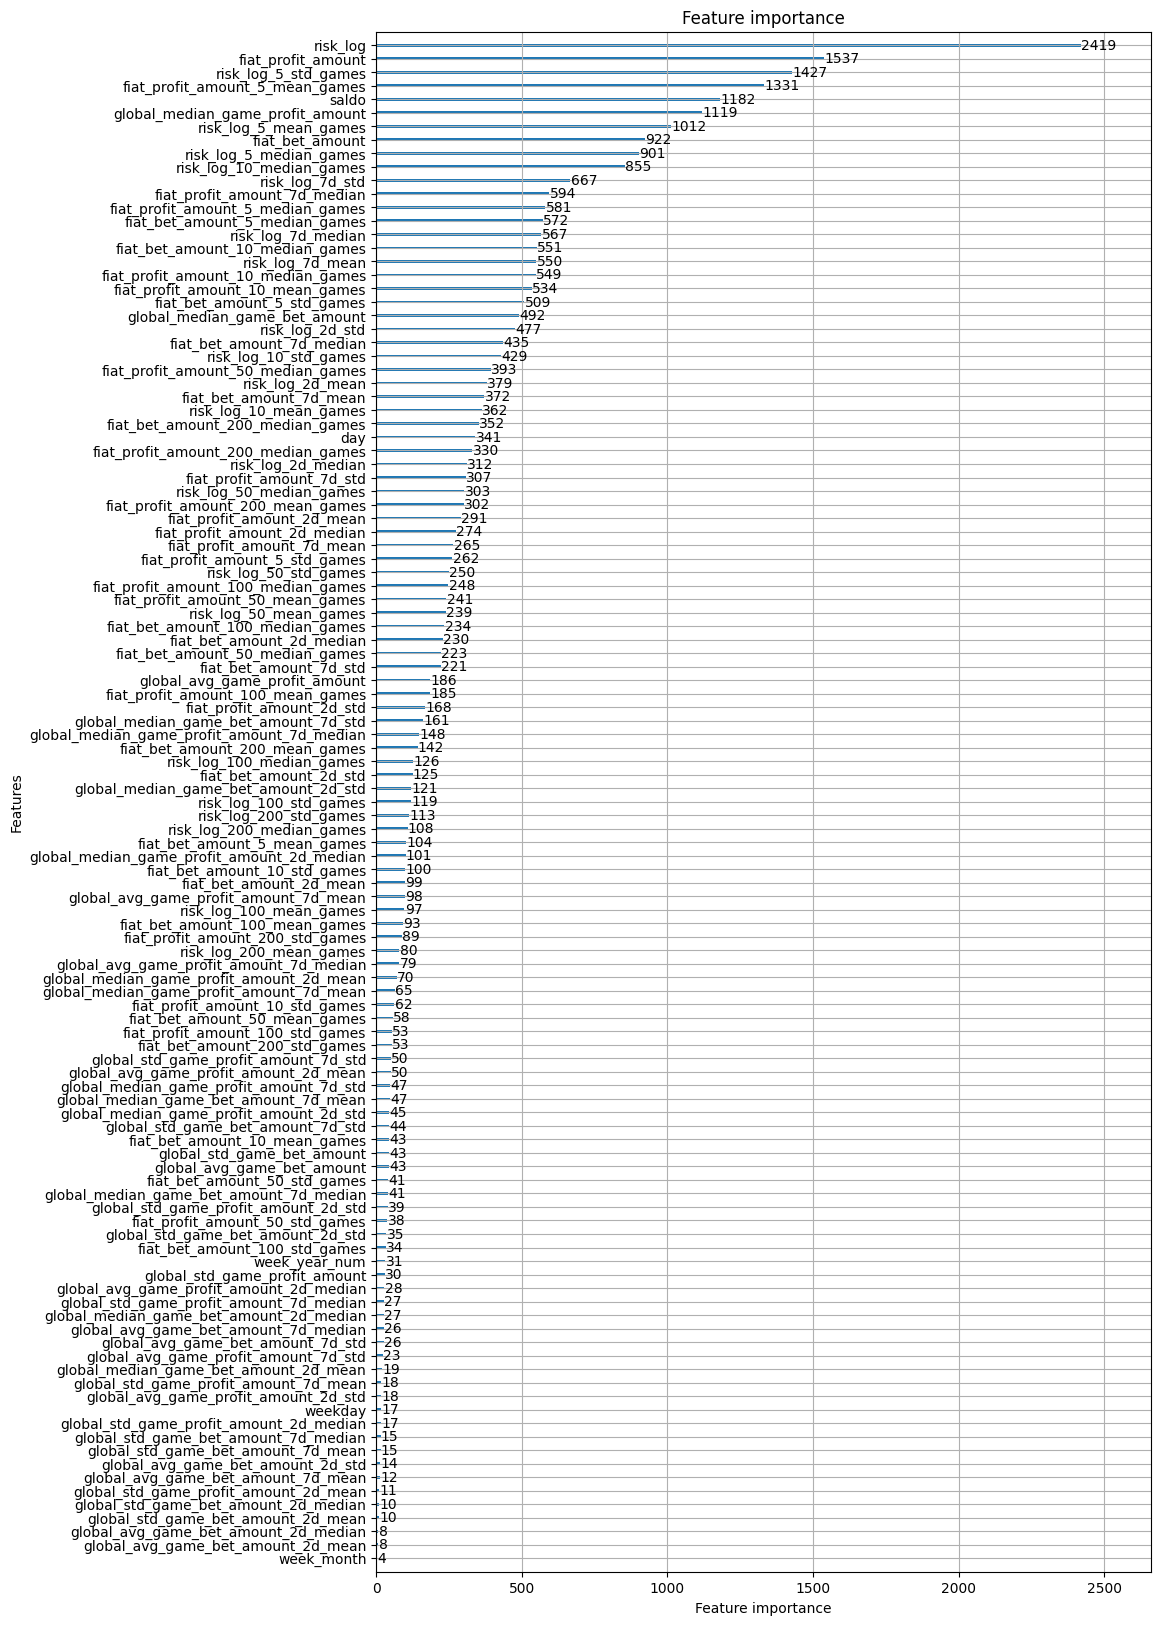

In [ ]:

plot_importance(model, max_num_features=120, figsize=(10,20))
plt.show()


In [ ]:
def plot_overall(y_true, y_pred, sample=None):
    s_true = pd.Series(y_true).reset_index(drop=True)
    s_pred = pd.Series(y_pred).reset_index(drop=True)
    df = pd.DataFrame({'y_true': s_true, 'y_pred': s_pred}).dropna()
    if sample and len(df) > sample:
        df = df.sample(sample, random_state=42)

    df['abs_err'] = (df['y_true'] - df['y_pred']).abs()
    mae = metrics.mean_absolute_error(df['y_true'], df['y_pred'])
    rmse = metrics.mean_squared_error(df['y_true'], df['y_pred'], squared=False)
    r2 = metrics.r2_score(df['y_true'], df['y_pred'])

    plt.figure(figsize=(8, 8))
    sc = plt.scatter(df['y_true'], df['y_pred'], c=df['abs_err'],
                     cmap='viridis', alpha=0.6, s=12, edgecolors='none')
    a = min(df['y_true'].min(), df['y_pred'].min())
    b = max(df['y_true'].max(), df['y_pred'].max())
    plt.plot([a, b], [a, b], 'k--', lw=1)
    cb = plt.colorbar(sc, pad=0.01); cb.set_label('|erro|')
    plt.xlabel('y_true'); plt.ylabel('y_pred')
    plt.title(f'Desempenho geral | MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}')
    plt.tight_layout(); plt.show()



c:\Users\mathe\repos\tcc\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


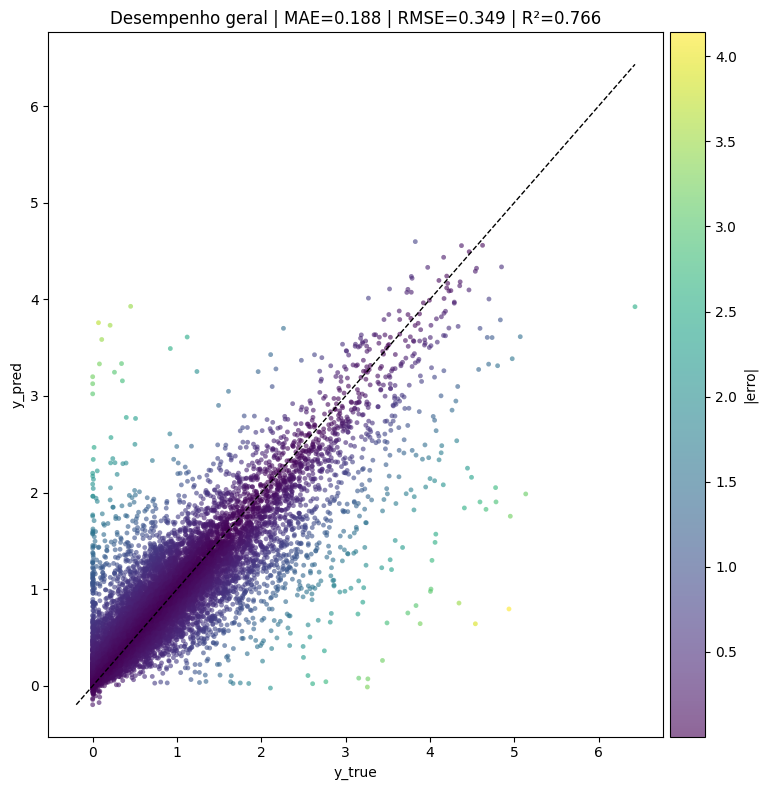

In [ ]:
plot_overall(y_test, y_pred, sample=20000)  


In [ ]:
# def plot_selected_bets(user_bets):
#     u = user_bets.copy()

#     plots = [
#         ("saldo", "Saldo acumulado", "red"),
#         ("fiat_bet_amount", "Valor apostado", "green"),
#         ("risk_log", "Risco (log)", "purple"),
#     ]

#     for col, title, line_color in plots:
#         plt.figure(figsize=(20, 5))
#         plt.plot(u["n_aposta"], u[col], marker="o", color=line_color)
#         plt.axhline(y=0, color="gray", linewidth=0.5, linestyle="--")
#         plt.xlabel("n_aposta")
#         plt.ylabel(col)
#         plt.title(f"{title} ao longo das apostas (n={len(u)})")
#         plt.grid(True, linestyle="--", alpha=0.5)
#         plt.tight_layout()
#         plt.show()


In [ ]:
train_meta = meta.loc[X_train.index].copy()

train = pd.DataFrame({
    "predicted": False,
    "risk": y_train,
    "risk_pred": y_train,
    "user_id": train_meta["user_id"],
    "bet_id": train_meta["bet_id"]
})


In [ ]:
test_meta = meta.loc[X_test.index].copy()

test = pd.DataFrame({
    "predicted":True,
    "risk": y_test,
    "risk_pred": y_pred,
    "user_id": test_meta["user_id"],
    "bet_id": test_meta["bet_id"]
})

test.head()


predicted      risk  risk_pred  user_id     bet_id
index                                                       
9127492        True  0.515617   0.454474   369102   13345331
16191878       True  0.560618   0.718581  1419544  229241372
17193729       True  0.099603   0.272112  1192777  230359429
3365642        True  0.018821   0.096494  1440920  214738919
12000074       True  0.059349   0.336767   118143  224556927

In [ ]:
df_final = pd.concat([train,test]).sort_values("bet_id")


In [ ]:
df_final.columns


Index(['predicted', 'risk', 'risk_pred', 'user_id', 'bet_id'], dtype='object')

In [ ]:
df_final.head(100)


predicted      risk  risk_pred  user_id    bet_id
index                                                   
98         False  0.072636   0.072636  1264181  12148530
51         False  4.943514   4.943514  1032341  12148531
68         False  1.085189   1.085189  1179800  12148532
80         False  2.002201   2.002201  1205760  12148533
143        False  0.224907   0.224907  1365445  12148534
...          ...       ...        ...      ...       ...
622         True  0.180042   0.801538  1276963  12148630
747        False  0.690530   0.690530  1430942  12148631
600         True  1.586092   1.399894  1243927  12148632
523        False  3.244498   3.244498   728412  12148633
492        False  0.204352   0.204352   204643  12148634

[100 rows x 5 columns]

In [ ]:
def plot_user_series(
    df, 
    user_id, 
    max_points=100, 
    smooth_window=1, 
    downsample_method="uniform",   # "uniform" | "random_block" | "none"
    random_state=42,
    marker=True
):
    u = df[df["user_id"] == user_id].copy()
        
    original_n = len(u)
        
    win = max(1, min(smooth_window, max(1, len(u)//5)))
    risk_full      = u["risk"].rolling(win, center=True, min_periods=1).mean().to_numpy()
    risk_pred_full = u["risk_pred"].rolling(win, center=True, min_periods=1).mean().to_numpy()
    
    
    method_used = "none"
    if downsample_method == "uniform" and len(u) > max_points:
          idx = np.linspace(0, len(u) - 1, max_points).astype(int)
          u = u.iloc[idx]
          risk      = risk_full[idx]
          risk_pred = risk_pred_full[idx]
          method_used = f"uniform ({max_points})"
    
    elif downsample_method == "random_block" and len(u) > max_points:
          rng = np.random.RandomState(random_state)
          start = rng.randint(0, len(u) - max_points + 1)
          idx = np.arange(start, start + max_points)
          u = u.iloc[idx]
          risk      = risk_full[idx]
          risk_pred = risk_pred_full[idx]
          method_used = f"random block ({max_points}, seed={random_state})"
    
    else:
          risk      = risk_full
          risk_pred = risk_pred_full
    

    x = np.arange(len(u))
    is_pred = u["predicted"].astype(bool).to_numpy() if "predicted" in u.columns else np.zeros(len(u), bool)
    
    
    resid = risk_pred - risk
    mae_test = float(np.mean(np.abs(resid[is_pred]))) if is_pred.any() else np.nan
    mae_all = np.mean(np.abs(df.loc[df.predicted == True, "risk_pred"] 
                             - df.loc[df.predicted == True, "risk"]))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 9), sharex=True, height_ratios=[2, 1])

    ax1.plot(x, risk_pred, label="Predicted risk",   color="#ff7f0e", linewidth=1.8)   # laranja
    ax1.plot(x, risk,      label="True risk",      color="#1f77b4", linewidth=1.8)   # azul
    
    ax1.fill_between(x, risk, risk_pred, alpha=0.25, color="gray")

    if marker:
      ax1.scatter(
          x[is_pred], risk_pred[is_pred],
          color="#ff7f0e", marker="x", s=90, linewidth=2.0,
          label="Test predicted points"
      )
      
      ax1.scatter(
          x[is_pred], risk[is_pred],
          color="#1f77b4", marker="o", s=70, edgecolor="black", linewidth=0.7,
          label="Test true points"
      )

    # ax1.xlabel("bet_id (ordem)")
    # ax1.ylabel("risk")
    
    title = f"Risk Analysis — User {user_id} | total bets={original_n}"

    if original_n != len(u):
        title += f" | downsampled to {len(u)} bets"
    if method_used != "none":
        title += f" | downsampling={method_used}"
    if smooth_window > 1:
        title += f" | smoothing={smooth_window}"
    ax1.set_title(title)
    
    ax1.grid(True, linestyle="--", alpha=0.3)
    ax1.legend()
    
    ax2.plot(x, resid, linewidth=1.5)
    ax2.axhline(0.0, linewidth=1.2)
    if marker:
      ax2.scatter(x[is_pred], resid[is_pred], marker="x", s=70, linewidth=2.0)

    ax2.set_xlabel("Bet order ")
    ax2.set_ylabel("Residuals")
    subtitle = f"Global MAE={mae_all:.4f}"
    if is_pred.any():
        subtitle += f" | User MAE ={mae_test:.4f}"
    ax2.set_title(subtitle)
    ax2.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_user_profile(
    df,
    user_id,
    max_points=300,
    smooth_window=1,
    downsample_method="uniform",
    random_state=42
):
    u = df[df["user_id"] == user_id].copy()

    original_n = len(u)

    win = max(1, min(smooth_window, max(1, len(u) // 5)))

    def smooth(arr):
        return arr.rolling(win, center=True, min_periods=1).mean().to_numpy()

    metrics = {
        "saldo": ("Saldo acumulado", "red"),
        "fiat_bet_amount": ("Valor apostado", "green"),
        "risk_log": ("Risco (log)", "purple"),
    }

    def apply_downsample(arr, u_df):
        n = len(arr)
        if downsample_method == "uniform" and n > max_points:
            idx = np.linspace(0, n - 1, max_points).astype(int)
        elif downsample_method == "random_block" and n > max_points:
            rng = np.random.RandomState(random_state)
            start = rng.randint(0, n - max_points + 1)
            idx = np.arange(start, start + max_points)
        else:
            idx = np.arange(n)
        return arr[idx], u_df.iloc[idx], idx


    for col, (title, color) in metrics.items():

        arr_full = smooth(u[col])
        arr, u_ds, idx = apply_downsample(arr_full, u)

        x = u_ds["n_aposta"].to_numpy()

        plt.figure(figsize=(20, 5))
        plt.plot(x, arr, color=color, linewidth=1.8)

        plt.axhline(y=0, color="gray", linewidth=0.6, linestyle="--")
        plt.grid(True, linestyle="--", alpha=0.4)

        ttl = f"{title} ao longo das apostas | usuário {user_id}"
        ttl += f" | total={original_n}"
        if len(arr) != original_n:
            ttl += f" | downsample={len(arr)} ({downsample_method})"
        if smooth_window > 1:
            ttl += f" | smooth={win}"

        plt.title(ttl)
        plt.xlabel("n_aposta")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

    if "day" in u.columns:
        u_day = u.copy()

        agg = u_day.groupby("day").agg({
            "fiat_bet_amount": "mean",
            "saldo": "mean",
            "risk_log": "mean",
        }).reset_index()

        # suavização leve opcional
        agg_smooth = agg.copy()
        for col in ["fiat_bet_amount", "saldo", "risk_log"]:
            agg_smooth[col] = agg_smooth[col].rolling(win, center=True, min_periods=1).mean()

        # plot risco médio por dia
        plt.figure(figsize=(20,5))
        plt.plot(agg["day"], agg_smooth["risk_log"], color="purple", linewidth=2)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.title(f"Risco médio por dia — Usuário {user_id}")
        plt.xlabel("Dia")
        plt.ylabel("Risco médio (log)")
        plt.tight_layout()
        plt.show()

        # plot valor médio apostado por dia
        plt.figure(figsize=(20,5))
        plt.plot(agg["day"], agg_smooth["fiat_bet_amount"], color="green", linewidth=2)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.title(f"Valor médio apostado por dia — Usuário {user_id}")
        plt.xlabel("Dia")
        plt.ylabel("Média de aposta")
        plt.tight_layout()
        plt.show()

        # plot saldo médio por dia
        plt.figure(figsize=(20,5))
        plt.plot(agg["day"], agg_smooth["saldo"], color="red", linewidth=2)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.title(f"Saldo médio por dia — Usuário {user_id}")
        plt.xlabel("Dia")
        plt.ylabel("Saldo médio")
        plt.tight_layout()
        plt.show()


In [ ]:
df_small = df[['user_id','risk_log','game_id','saldo']].copy()
out = (
    df_small.groupby('user_id', sort=False)
            .agg(avg_risk=('risk_log','mean'),
                 game_count=('game_id','nunique'),
                 saldo=('saldo','sum'))
            .reset_index()
)
out.sort_values('avg_risk')


C:\Users\mathe\AppData\Local\Temp\ipykernel_26324\567613512.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_small.groupby('user_id', sort=False)


user_id  avg_risk  game_count      saldo
15026  1455307  0.001087         741   0.001530
9705   1016819  0.005179         288   4.813673
20461  1232934  0.005303         463   0.804410
16089  1457891  0.005930         183  -1.000489
1423    135012  0.006565         239 -60.222683
...        ...       ...         ...        ...
32097  1503449       NaN           0   0.000000
32098  1503461       NaN           0   0.000000
32099  1503501       NaN           0   0.000000
32100  1503542       NaN           0   0.000000
32101  1503546       NaN           0   0.000000

[32102 rows x 4 columns]

In [ ]:
valid_players = out[out['avg_risk']>2.00].sort_values('avg_risk')
valid_players = valid_players[(valid_players['game_count'] > 90) & (valid_players['game_count'] < 110)].sort_values('avg_risk')
valid_players


user_id  avg_risk  game_count        saldo
17252  1299244  2.021142          92    18.735853
22200  1482796  2.023234          94     0.000578
6536    240794  2.023832          94   171.115753
23578  1424570  2.039244         104     0.122308
25513  1496227  2.039536          95    67.386353
11965  1166754  2.042095          97 -8011.448242
14700   668700  2.042975          97  -452.491638
9146    405811  2.055720         103    -0.398018
10826  1427661  2.057240         102     0.042083
21427  1479136  2.057752         100     3.254016
26608  1497089  2.059232         105     4.221177
13441  1441608  2.079937         107     0.002942
20399  1474765  2.083259          99     5.862826
25295  1495369  2.084605          95     3.704173
16306  1459496  2.084787         108    51.523666
14916  1453641  2.085241          94    -1.055418
7631   1243990  2.085549         103   201.986603
11603  1445463  2.097696          95     0.119570
13276  1043051  2.108952         107     0.583360
3573   1005624  2.109655         102    16.951296
24661  1466072  2.110915          99   -42.346111
3959   1433649  2.112265         101    -7.398972
27172  1475934  2.113255          93     0.000122
12108   672511  2.117396          96    19.135323
24412  1481498  2.126544          99     0.027970
14964  1276983  2.132920         101   291.775208
23479  1484169  2.146259          96    -0.003801
26565  1499794  2.148762          95    -0.757070
25875  1043777  2.165959         106    21.930281
11773  1445869  2.168937         102    -0.019777
20430  1472014  2.171310          91     2.310045
7215   1411534  2.171887          92    -1.889621
7107   1004344  2.180799         103    -4.732989
22260  1483256  2.183106          98     0.426283
12123   766363  2.189041          99     0.001719
25307  1488138  2.189206         107     0.292948
27187  1501188  2.198436         103    -0.075541
5714   1435118  2.202198         108     0.089097
17736   913303  2.207350         106    13.852542
13348   796197  2.210676         100 -3365.953125
6928   1367535  2.233359         109     0.001535
25355  1462699  2.243396         104    -0.806126
11102  1444511  2.264806          98    70.987823
19241  1470205  2.282115         107    -0.665742
24183   393043  2.286418          97     9.243260
3392   1428100  2.290180         103     7.358293
15908   760203  2.301895         109    79.224350
16941  1456742  2.318135          93    18.005680
26582  1496684  2.320104          91     0.001311
1924   1376734  2.322835          91    -0.052510
7638   1425733  2.326952          96   -30.891926
21142  1477853  2.341006          97     0.054971
19333  1470494  2.345069         106    -0.237664
21492  1208562  2.380032          97    -5.414421
8196   1312807  2.395037         100     0.037853
18025   928899  2.418185          99     0.471806
19788  1472256  2.420255          91     3.315009
6231   1217540  2.473390          97     1.771856
24916  1465114  2.572609          91    -0.278620
23597  1489088  2.660399         103     0.047241

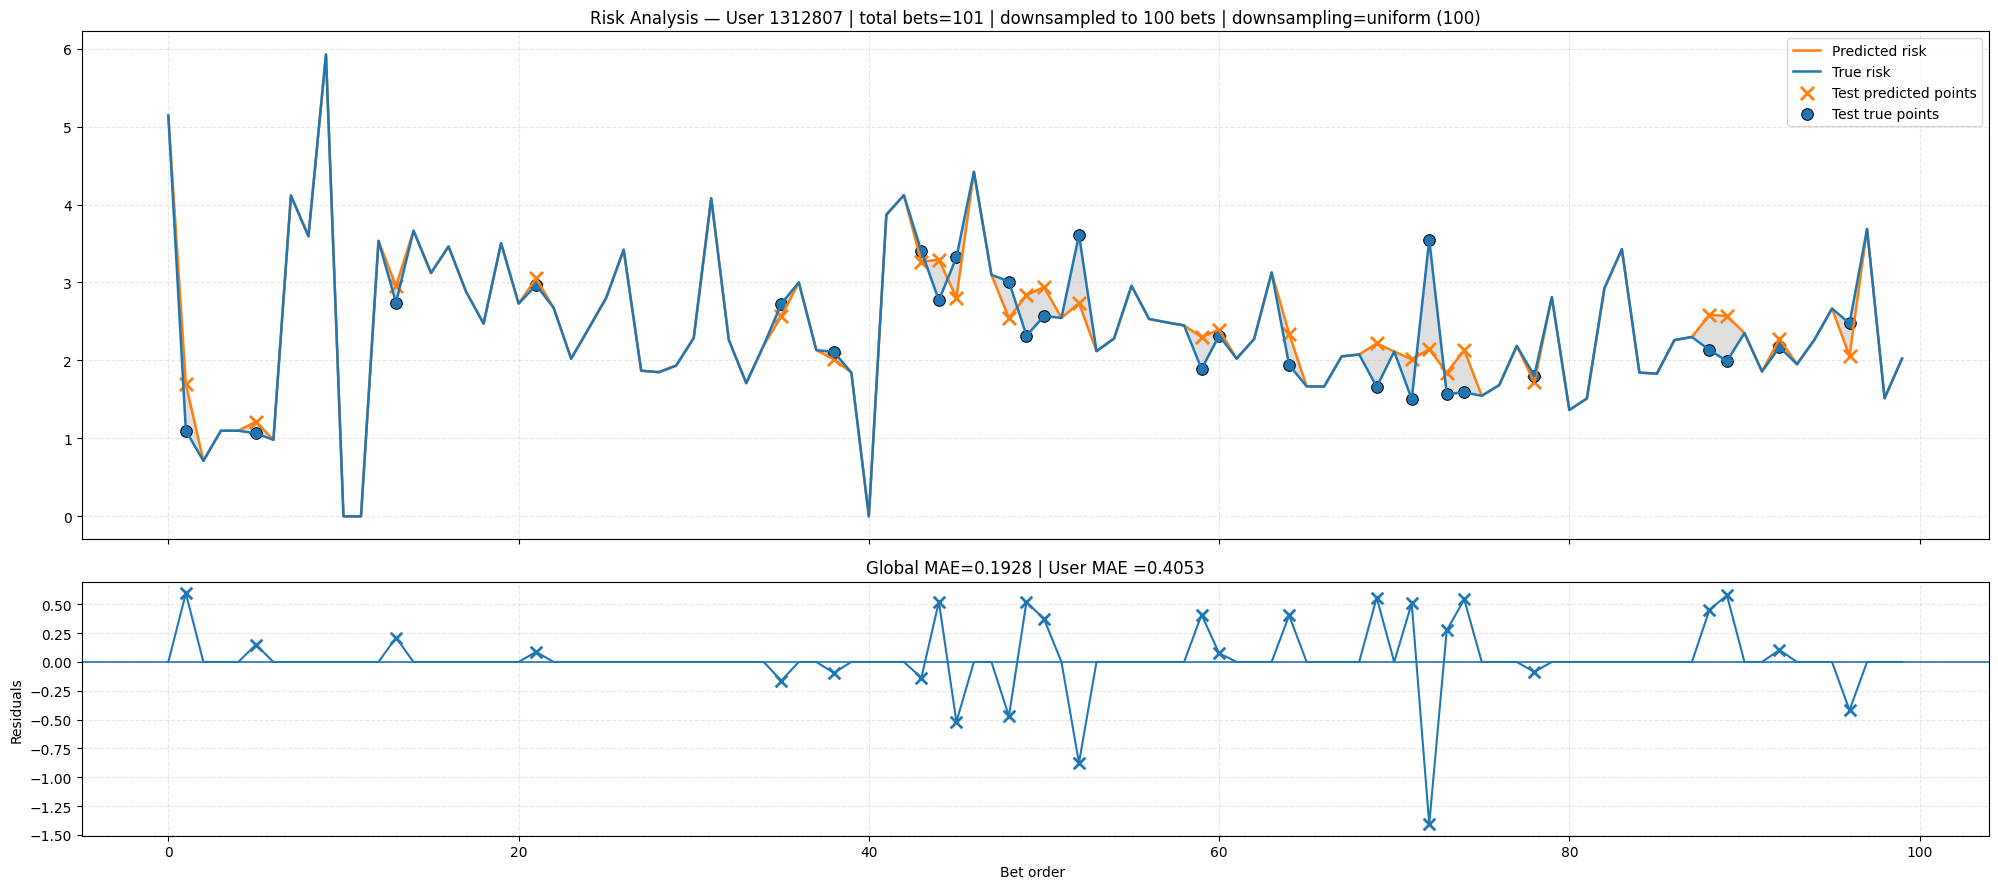

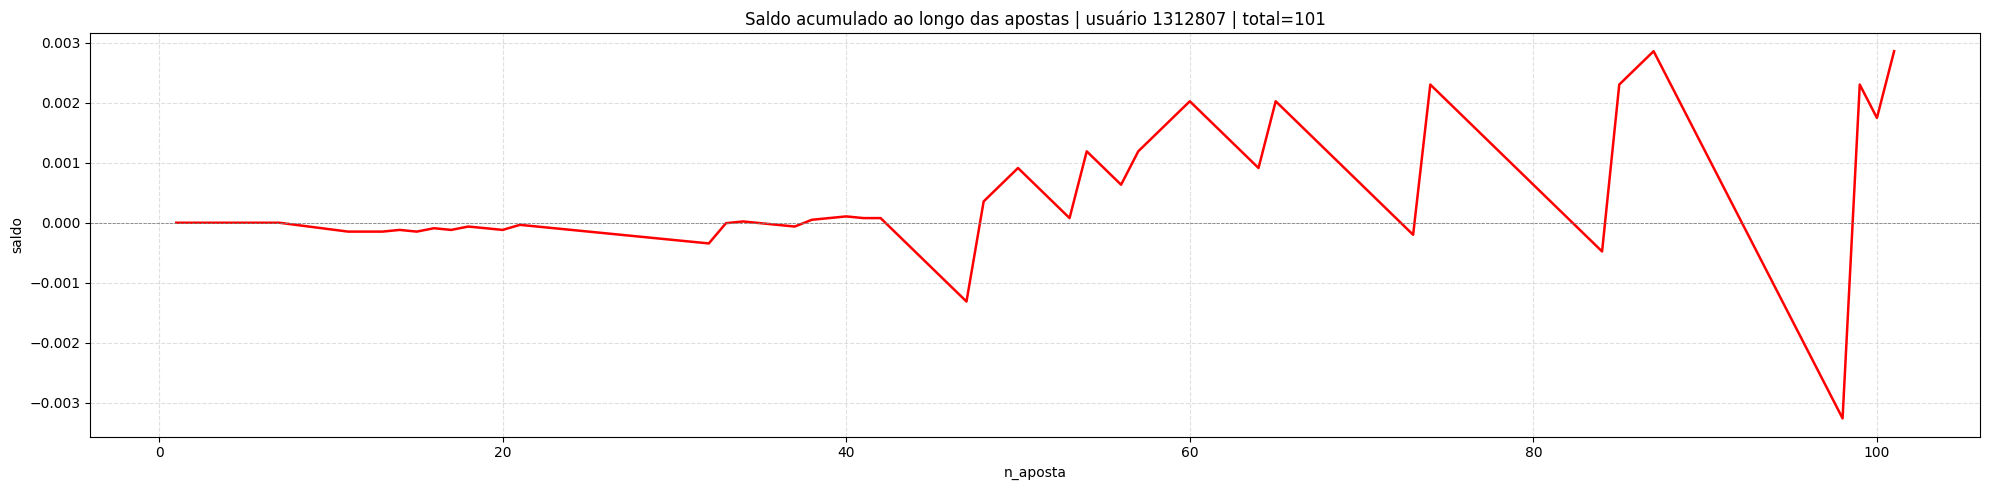

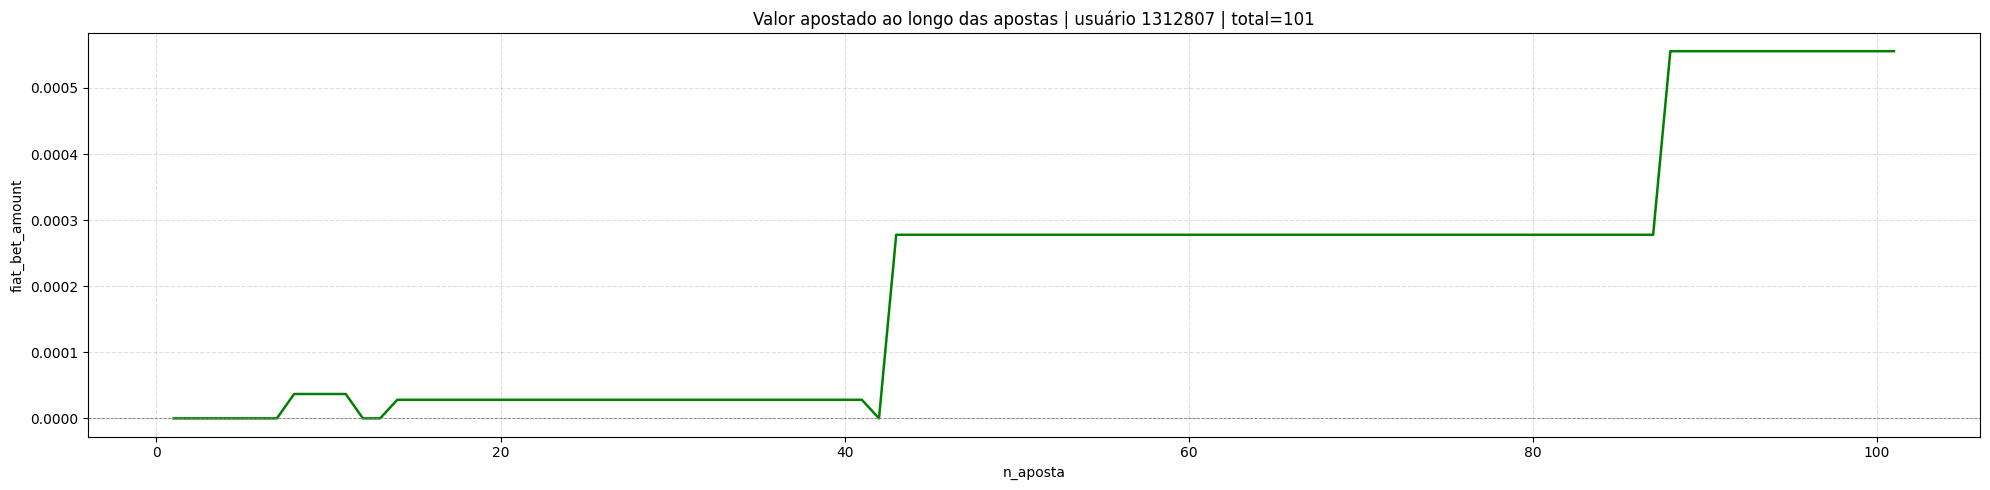

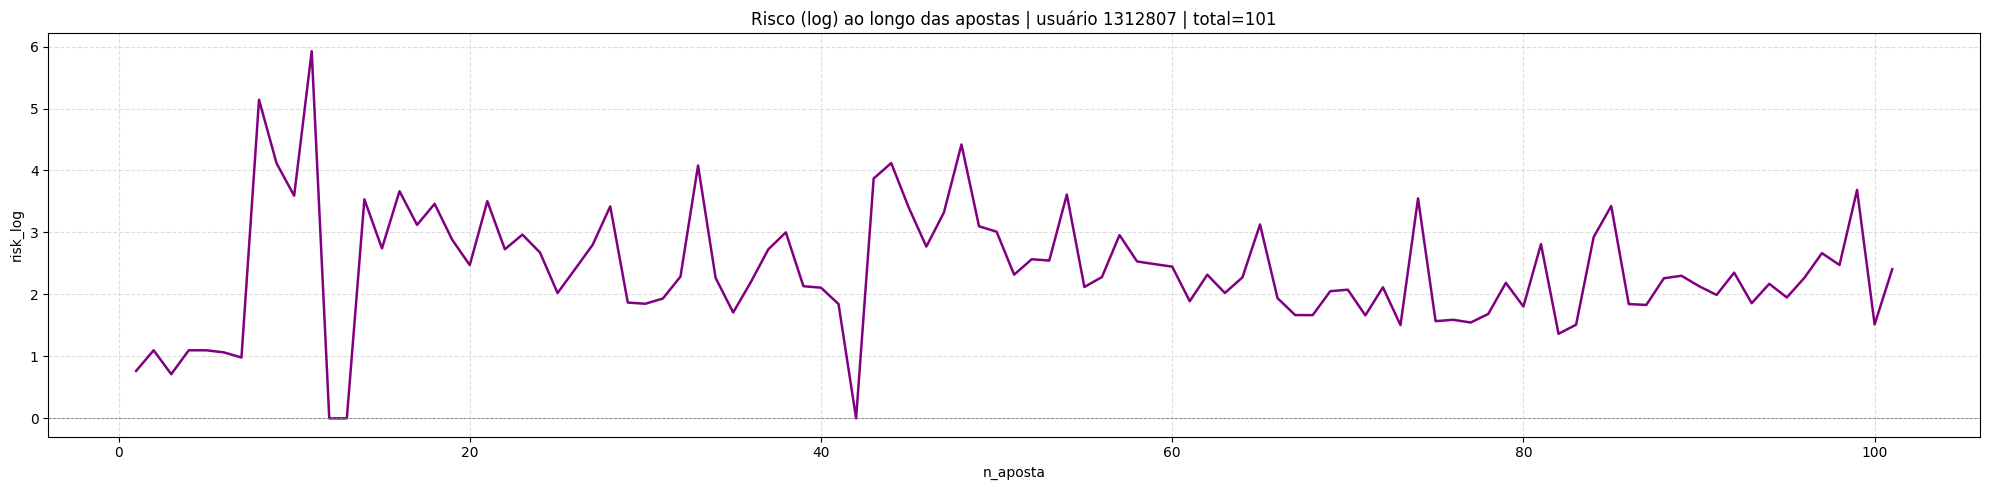

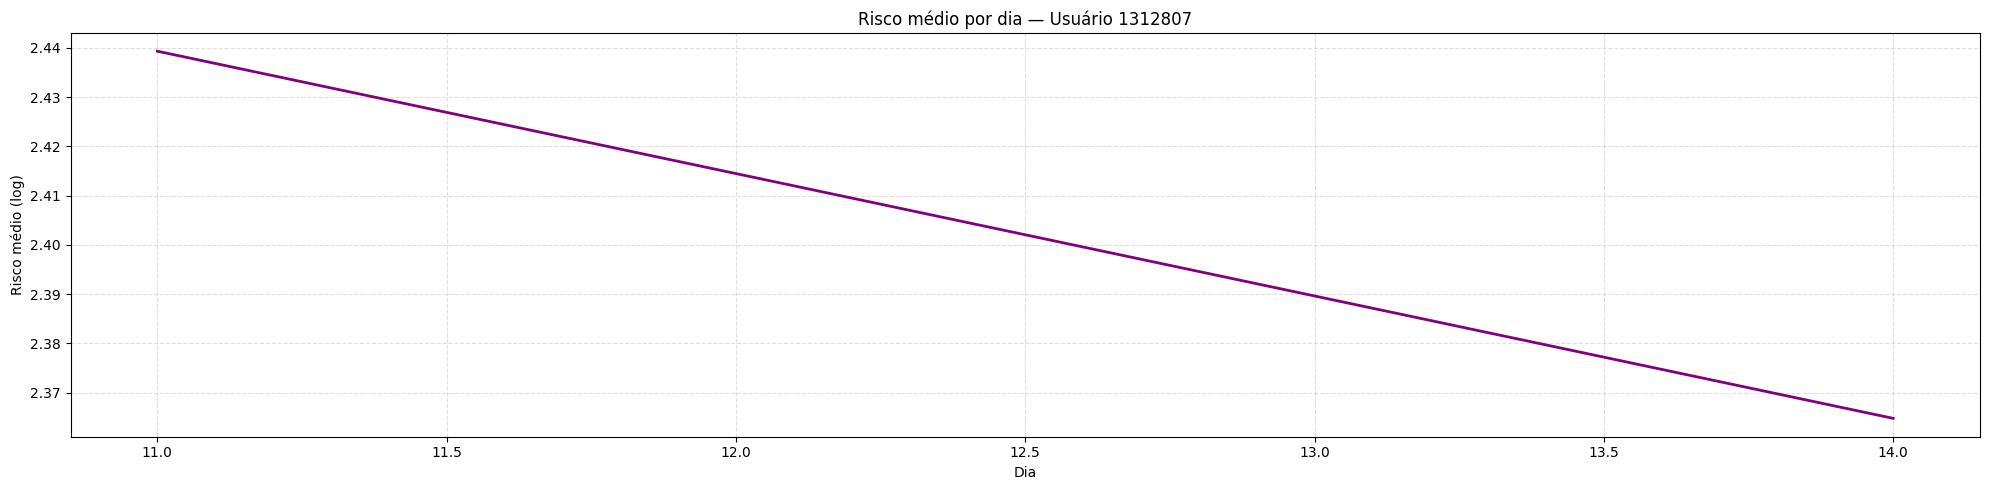

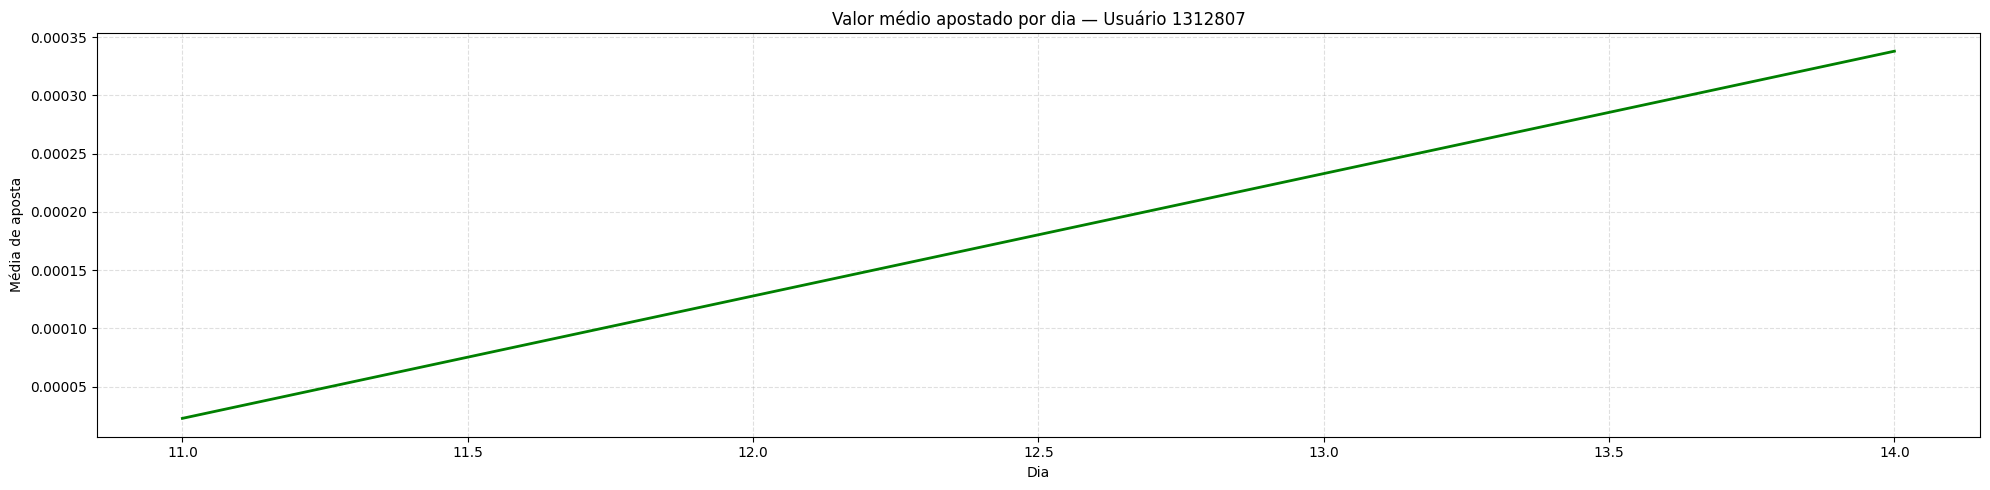

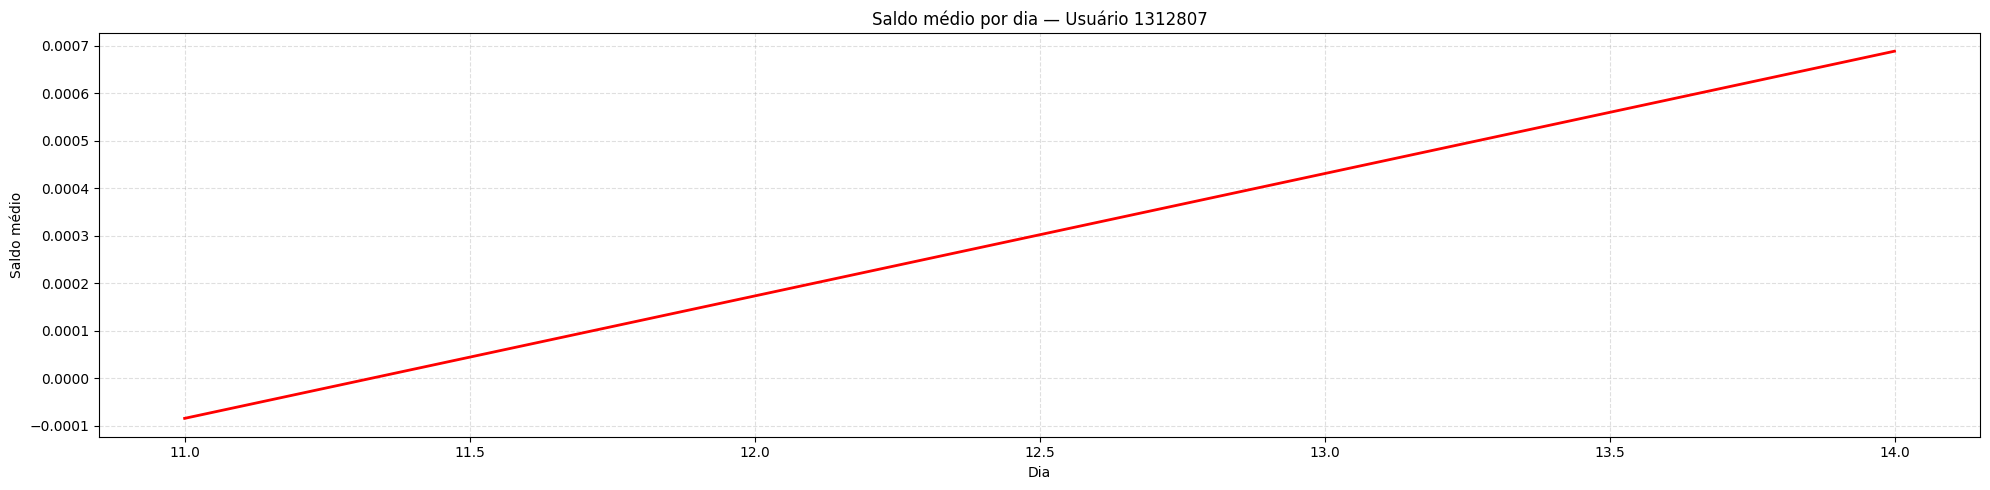

game_id  user_id     bet_id  fiat_bet_amount  fiat_profit_amount  \
index                                                                       
2218693  2835631  1312807  213418677     3.375277e-10       -3.375277e-10   
2219015  2835632  1312807  213419118     3.375277e-10        3.375277e-10   
2219346  2835633  1312807  213419501     3.375277e-10       -3.375277e-10   
2219678  2835634  1312807  213419792     3.375277e-10        3.375277e-10   
2220001  2835635  1312807  213420240     3.375277e-10        3.375277e-10   
...          ...      ...        ...              ...                 ...   
5422326  2845838  1312807  217026142     5.556124e-04       -5.556124e-04   
5422648  2845839  1312807  217026579     5.556124e-04       -5.556124e-04   
5422977  2845840  1312807  217027067     5.556124e-04       -5.556124e-04   
5423310  2845841  1312807  217027293     5.556124e-04        5.556124e-03   
5423649  2845842  1312807  217027729     5.556124e-04       -5.556124e-04   

                saldo  n_aposta  risk_log  global_avg_game_bet_amount  \
index                                                                   
2218693 -3.375277e-10         1  0.765468                    0.152945   
2219015  0.000000e+00         2  1.098612                    0.144471   
2219346 -3.375277e-10         3  0.712950                    0.309363   
2219678  0.000000e+00         4  1.098612                    0.306477   
2220001  3.375277e-10         5  1.098612                    0.270962   
...               ...       ...       ...                         ...   
5422326 -2.144898e-03        96  2.268181                    0.153198   
5422648 -2.700510e-03        97  2.665854                    0.158724   
5422977 -3.256123e-03        98  2.475229                    0.374545   
5423310  2.300001e-03        99  3.686064                    0.183120   
5423649  1.744389e-03       100  1.515403                    0.608799   

         global_median_game_bet_amount  ...  risk_log_200_mean_games  \
index                                   ...                            
2218693                       0.000188  ...                 0.765468   
2219015                       0.000389  ...                 0.932040   
2219346                       0.000214  ...                 0.859010   
2219678                       0.000244  ...                 0.918911   
2220001                       0.000121  ...                 0.954851   
...                                ...  ...                      ...   
5422326                       0.000123  ...                 2.386975   
5422648                       0.000111  ...                 2.389850   
5422977                       0.000106  ...                 2.390721   
5423310                       0.000073  ...                 2.403805   
5423649                       0.000110  ...                 2.394922   

         risk_log_200_std_games  risk_log_200_median_games  risk_next  year  \
index                                                                         
2218693                     NaN                   0.765468   1.098612  2020   
2219015                0.235569                   0.932040   0.712950  2020   
2219346                0.209157                   0.765468   1.098612  2020   
2219678                0.208606                   0.932040   1.098612  2020   
2220001                0.197727                   1.098612   1.064711  2020   
...                         ...                        ...        ...   ...   
5422326                1.005572                   2.271552   2.665854  2020   
5422648                1.000722                   2.274922   2.475229  2020   
5422977                0.995588                   2.277907   3.686064  2020   
5423310                0.999014                   2.280891   1.515403  2020   
5423649                0.997918                   2.277907   2.406614  2020   

         month  day  weekday  week_year_num  week_month  
index                             

In [ ]:
user = 1312807

plot_user_series(df_final,user) 
plot_user_profile(df, user)
df[df['user_id']==user].iloc[:100]


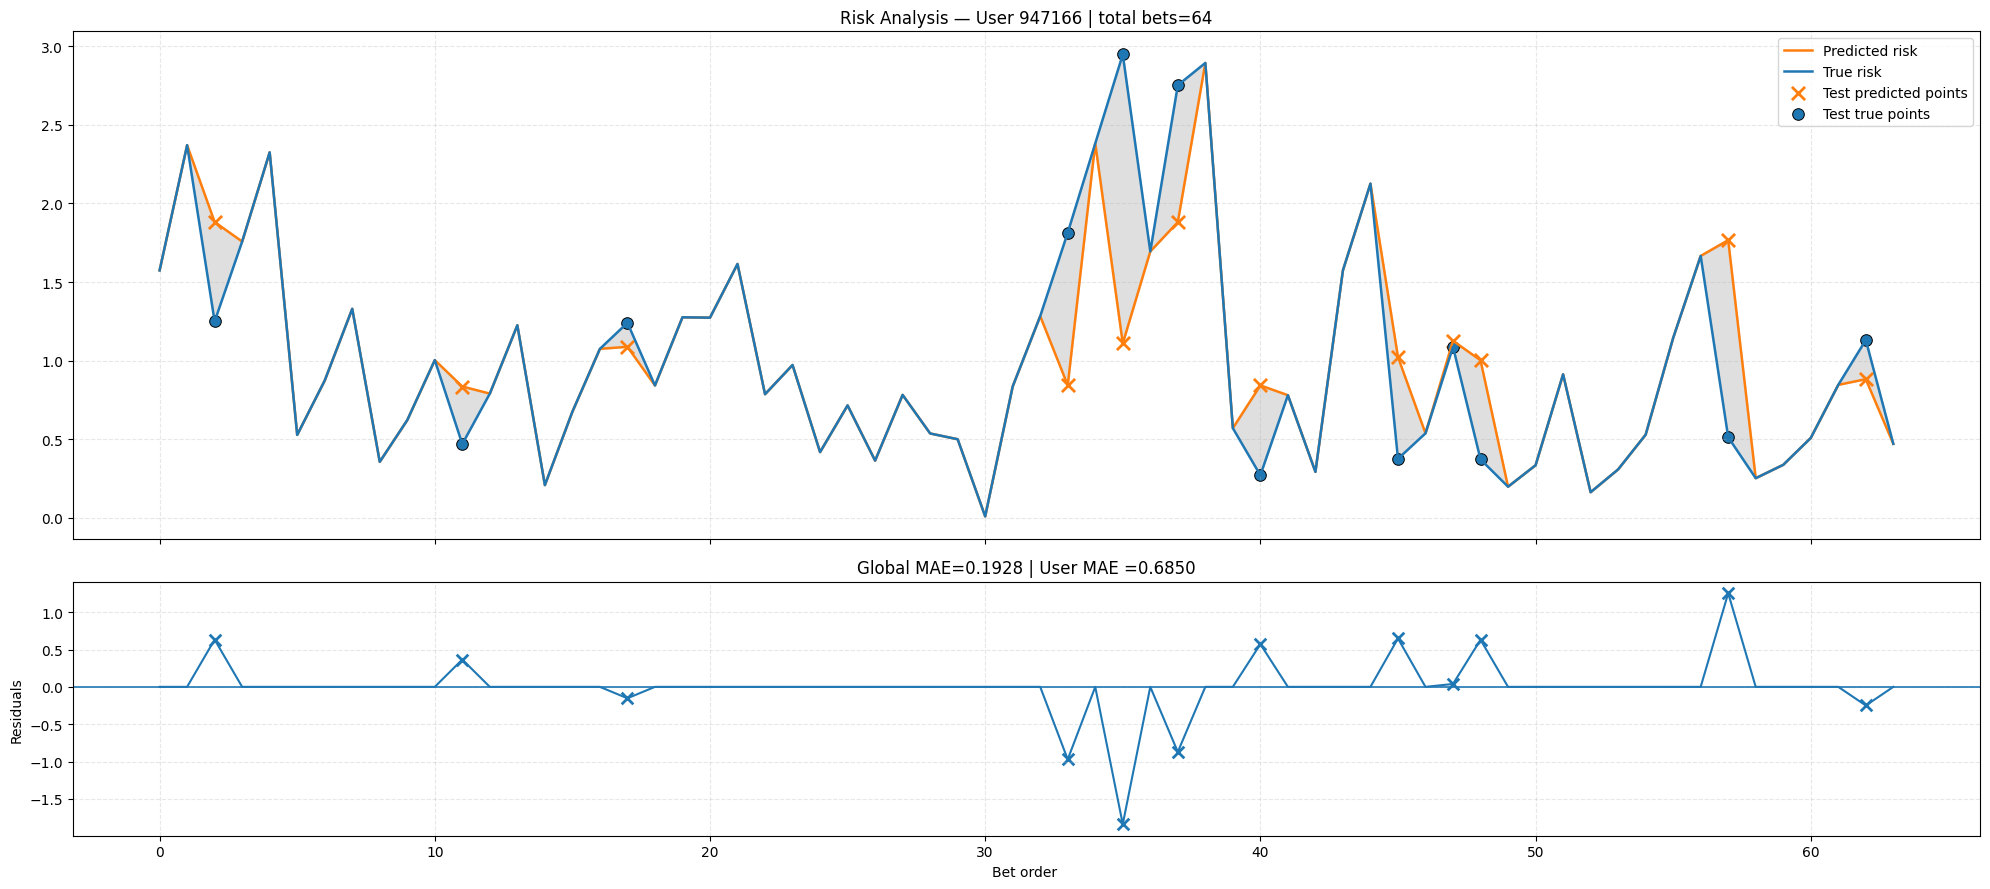

In [ ]:
plot_user_series(df_final,947166) 


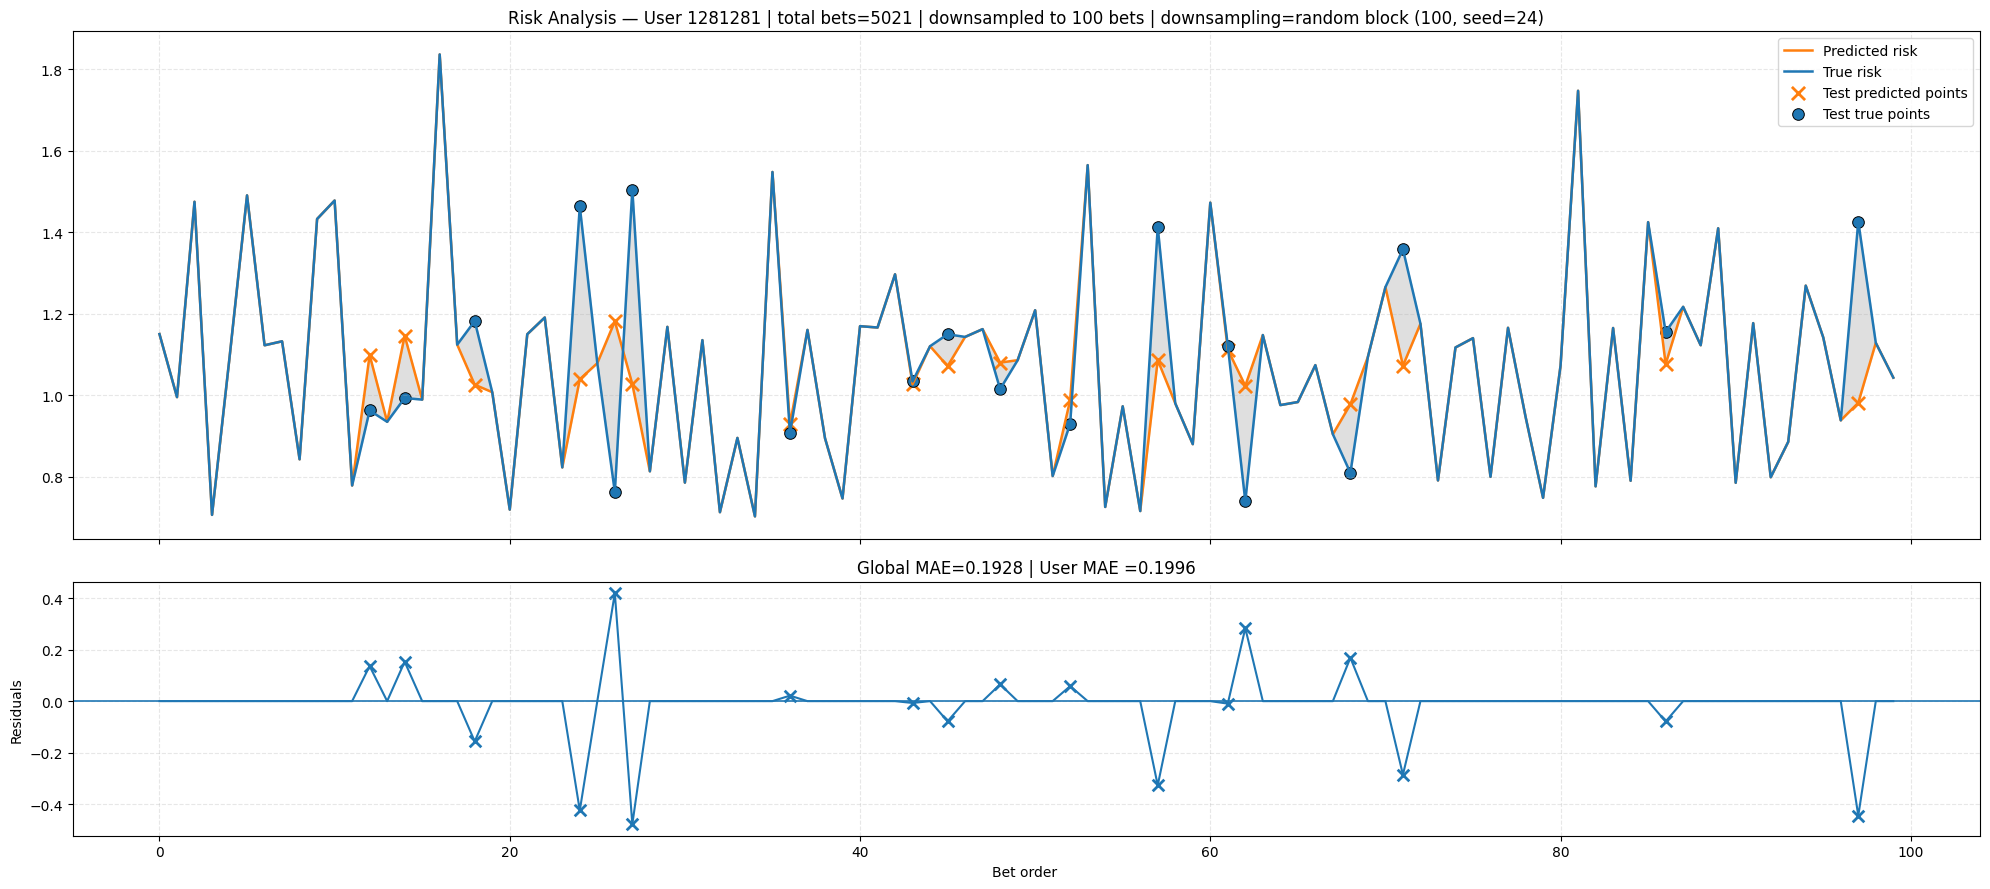

In [ ]:
plot_user_series(df_final,1281281, max_points=100, downsample_method="random_block", random_state=24)


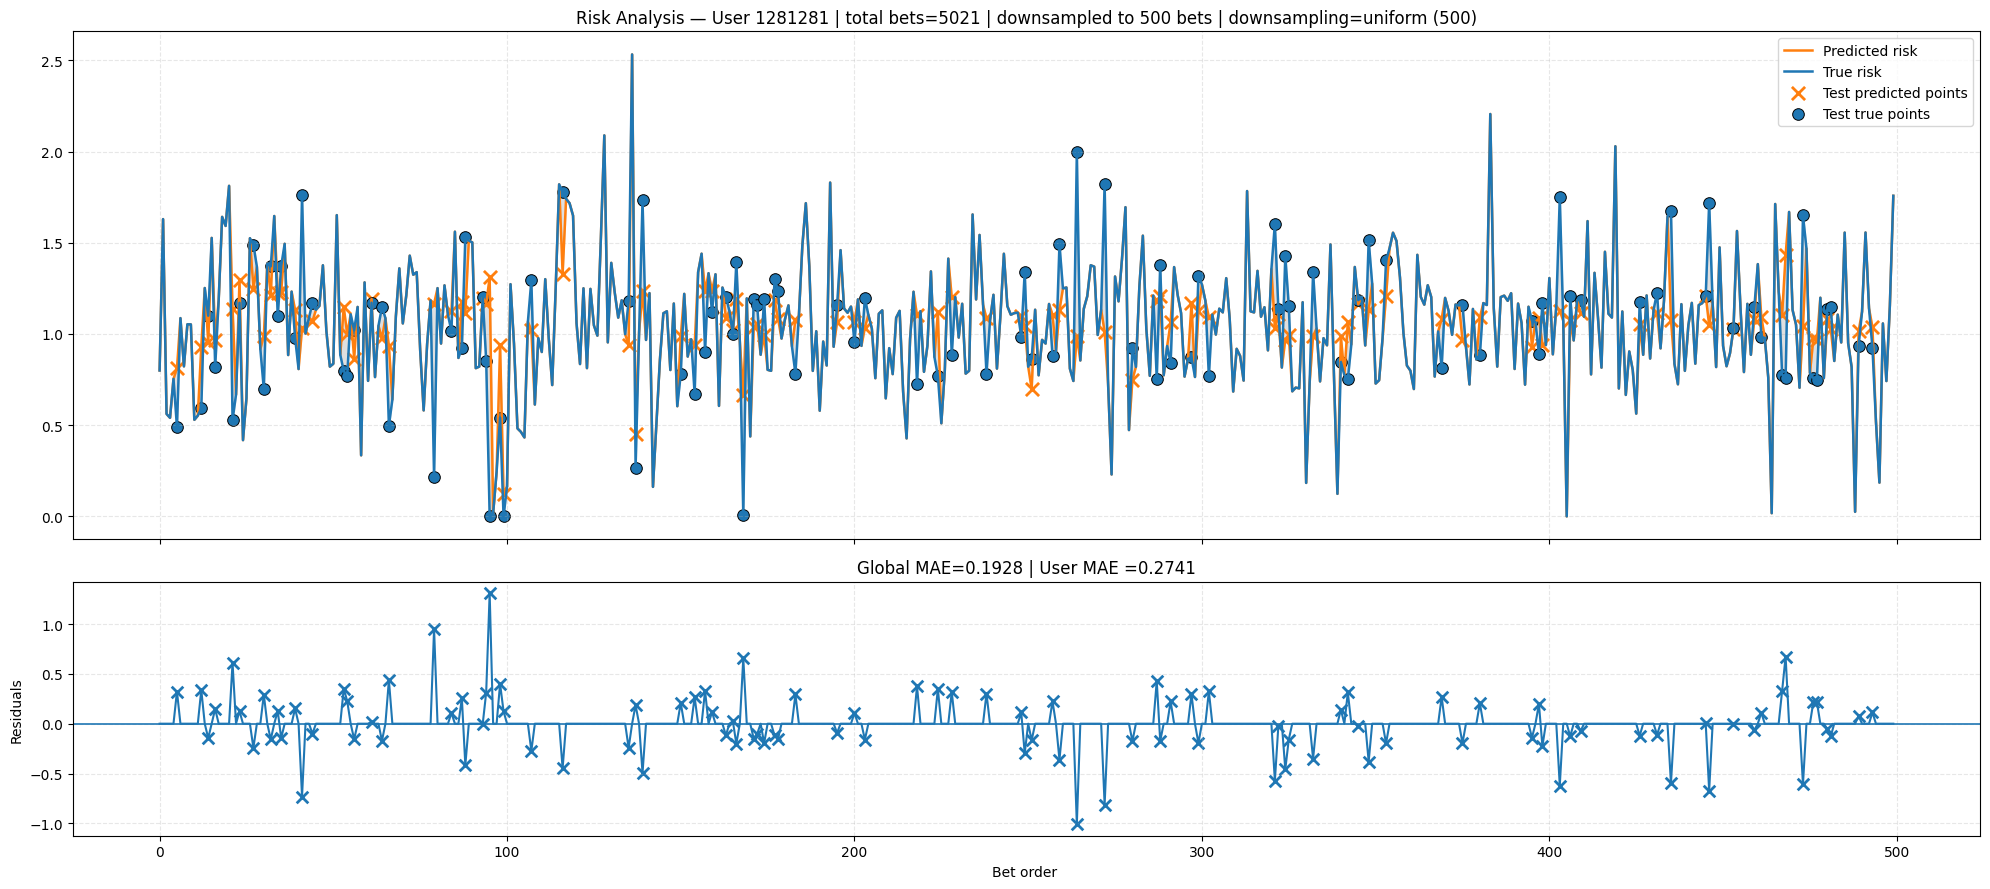

In [ ]:
plot_user_series(df_final,1281281, max_points=500, smooth_window=1)


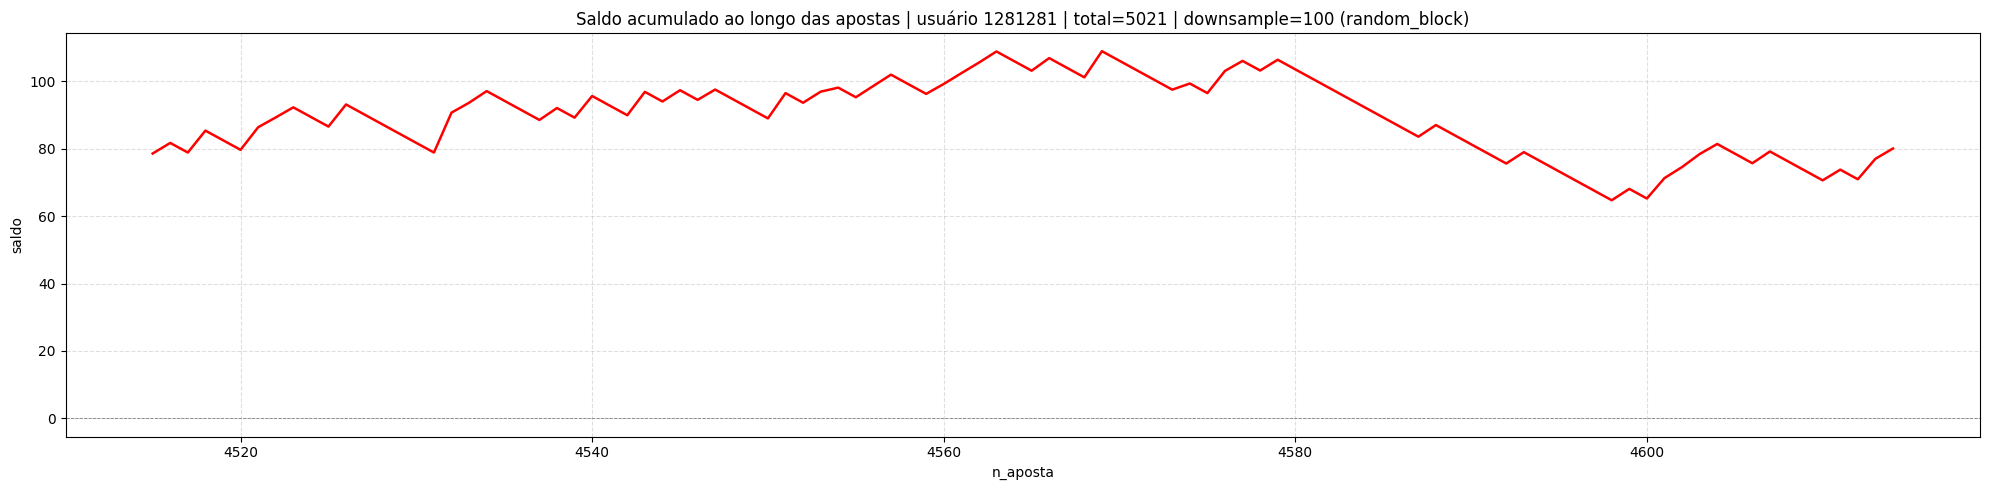

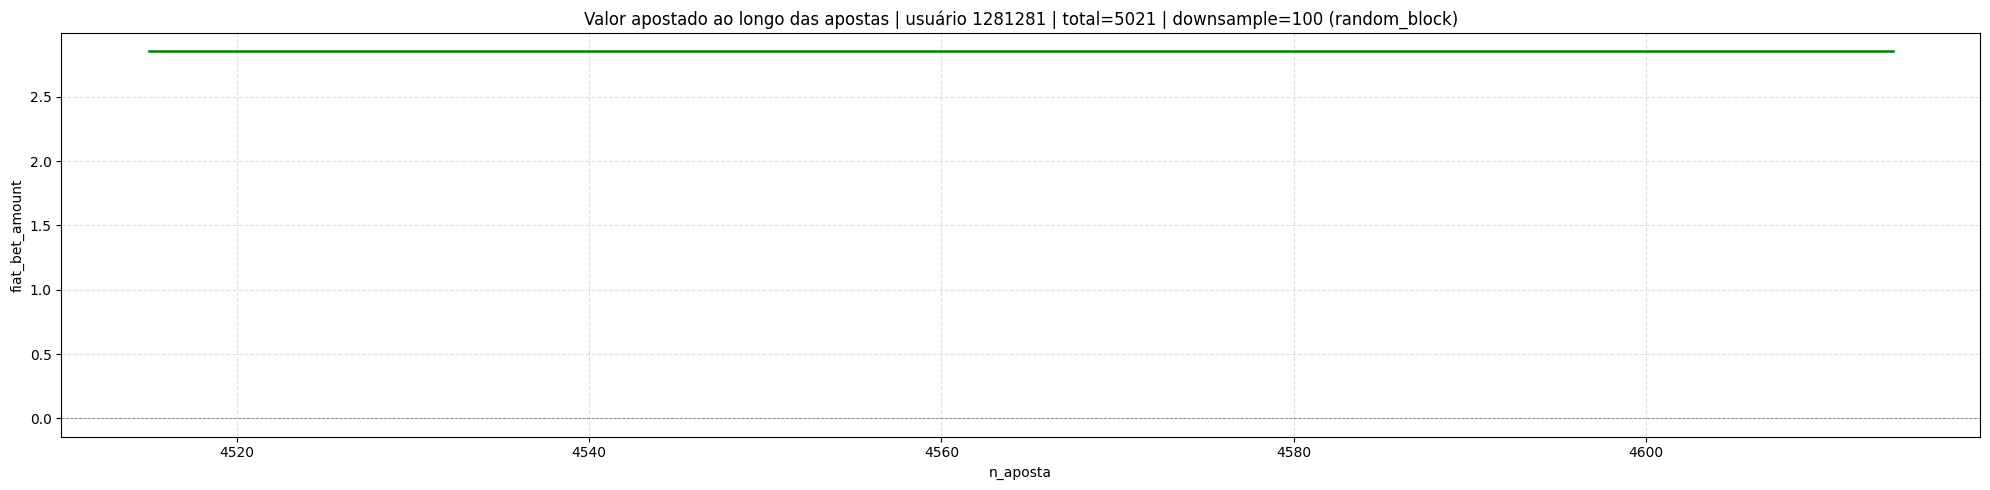

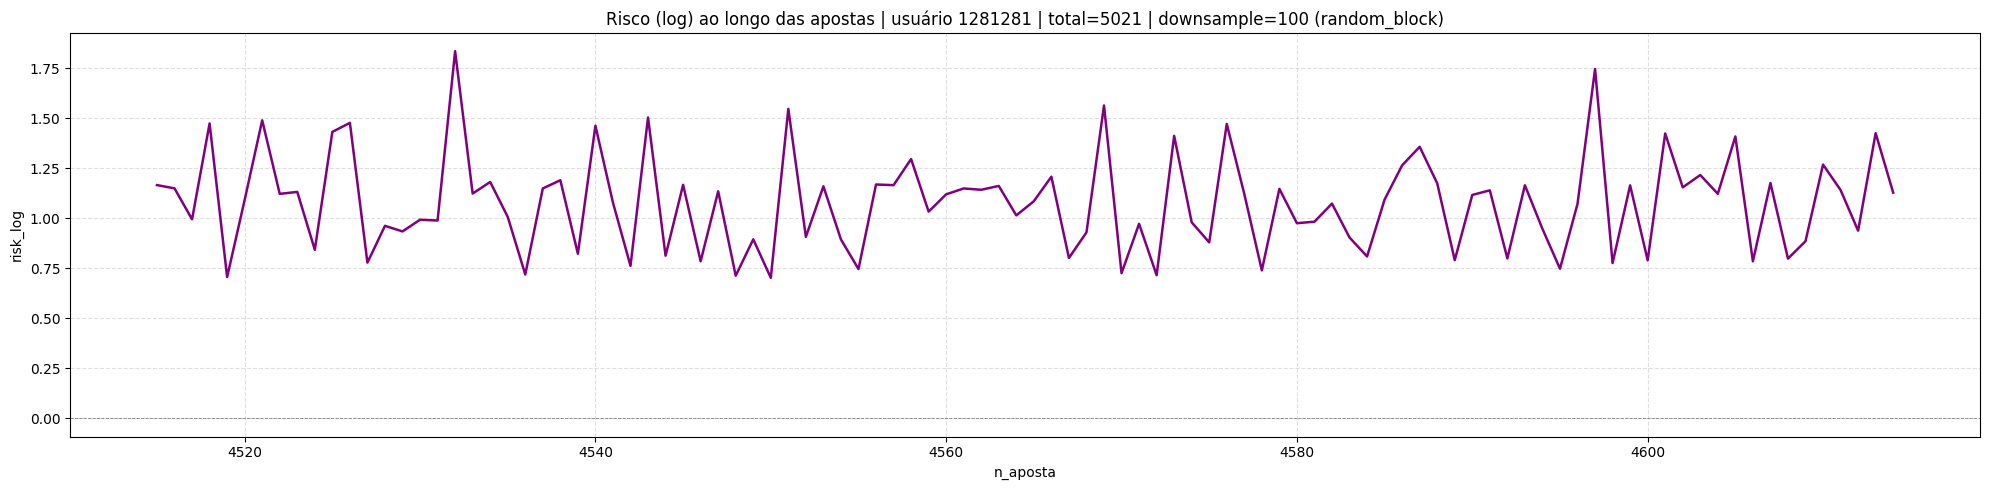

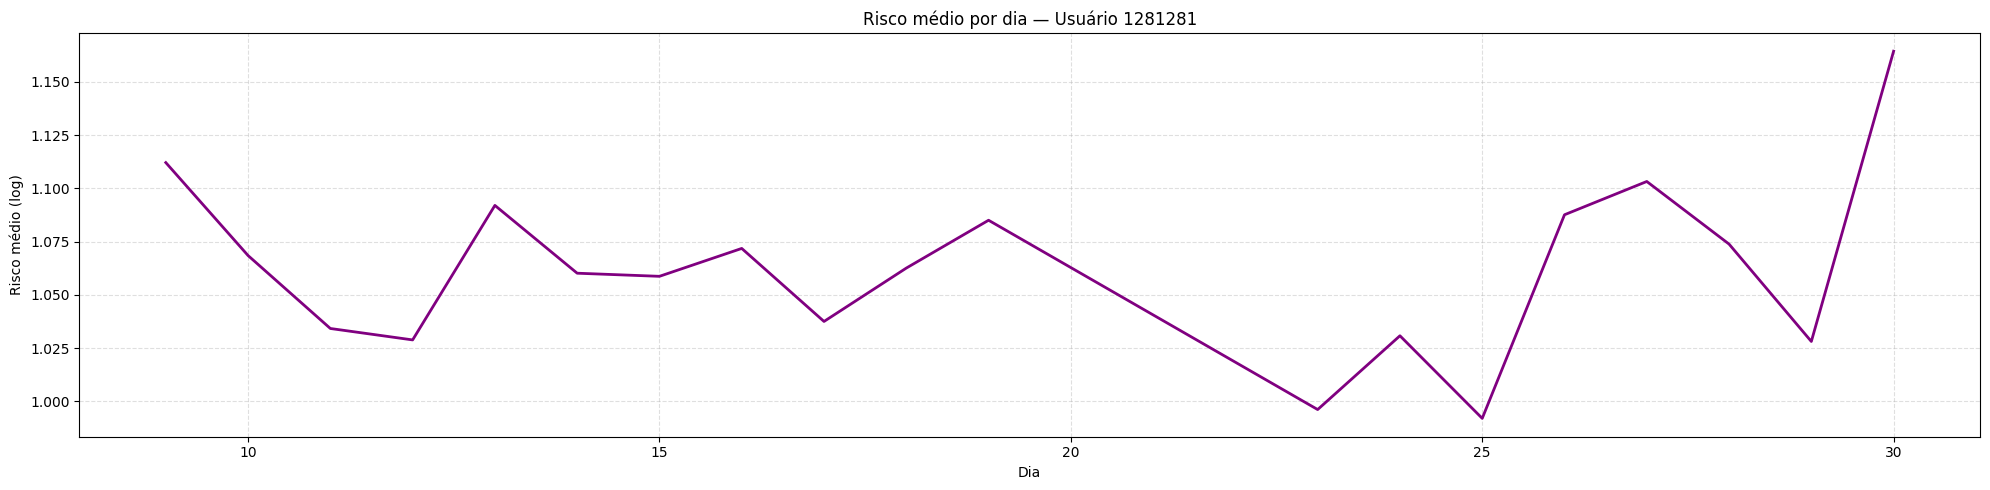

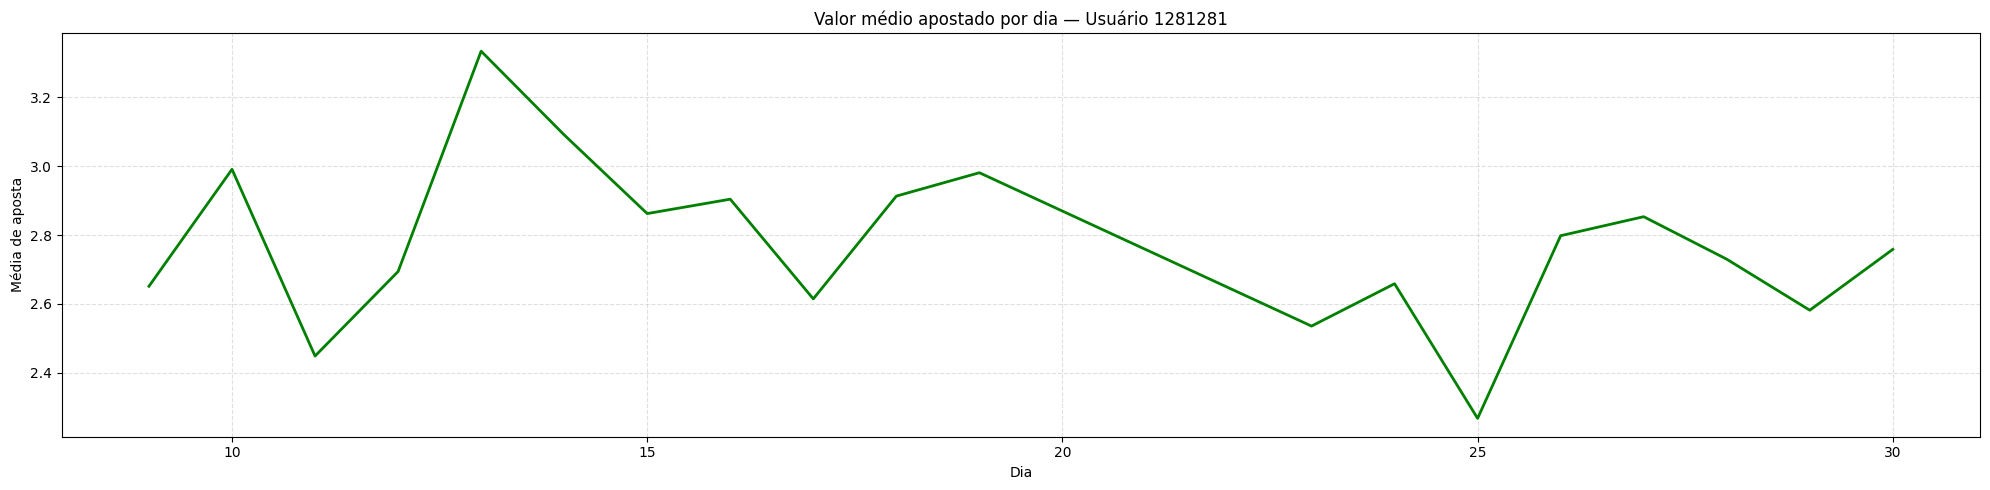

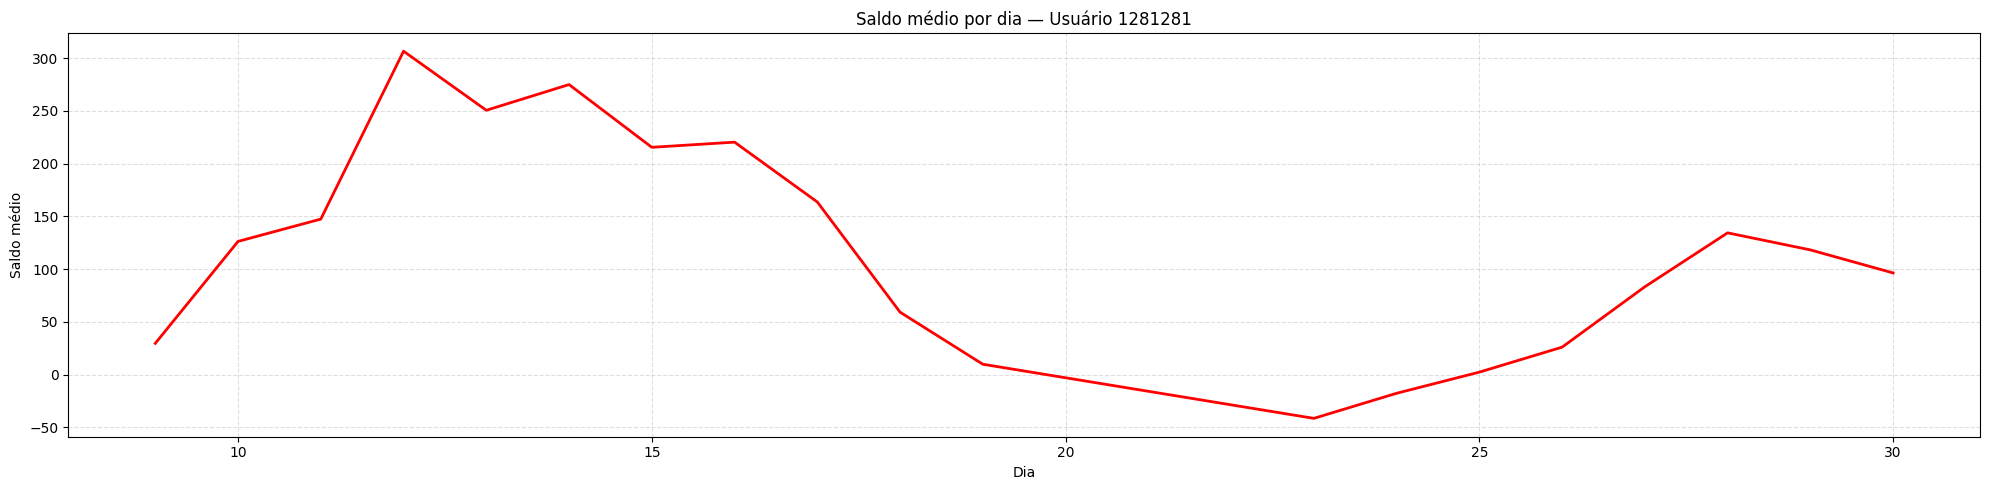

In [ ]:
plot_user_profile(df, 1281281, max_points=100, downsample_method="random_block", random_state=24)


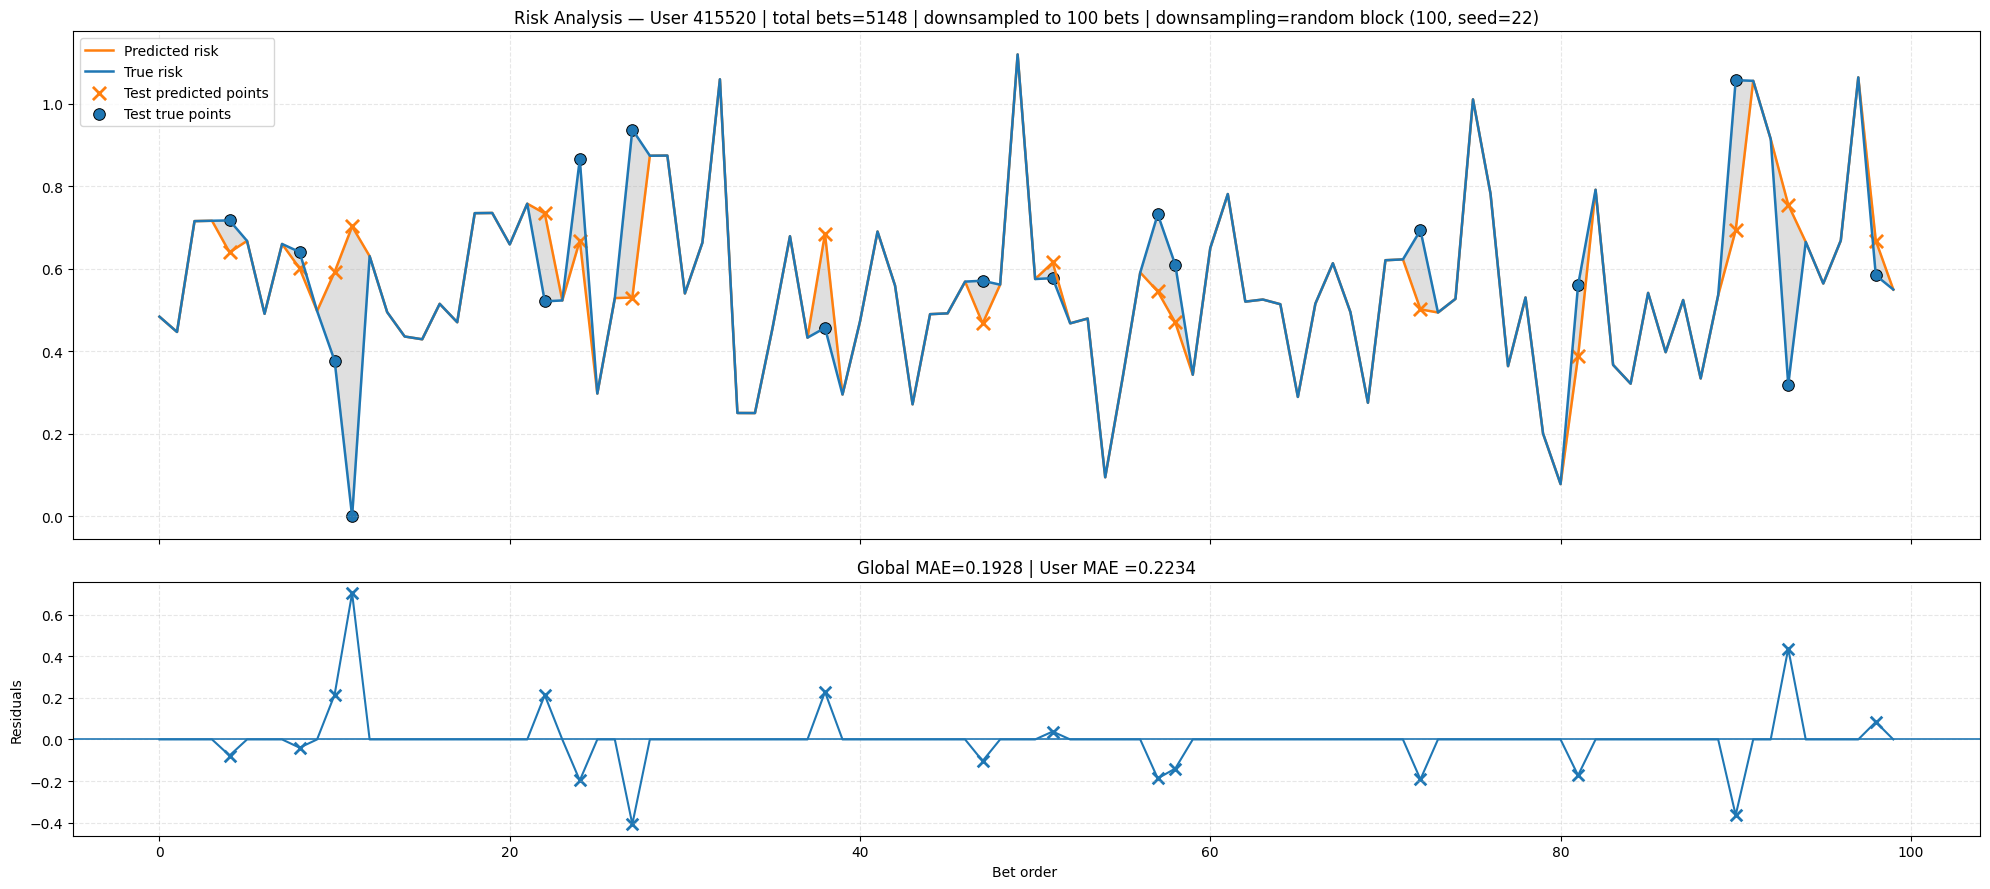

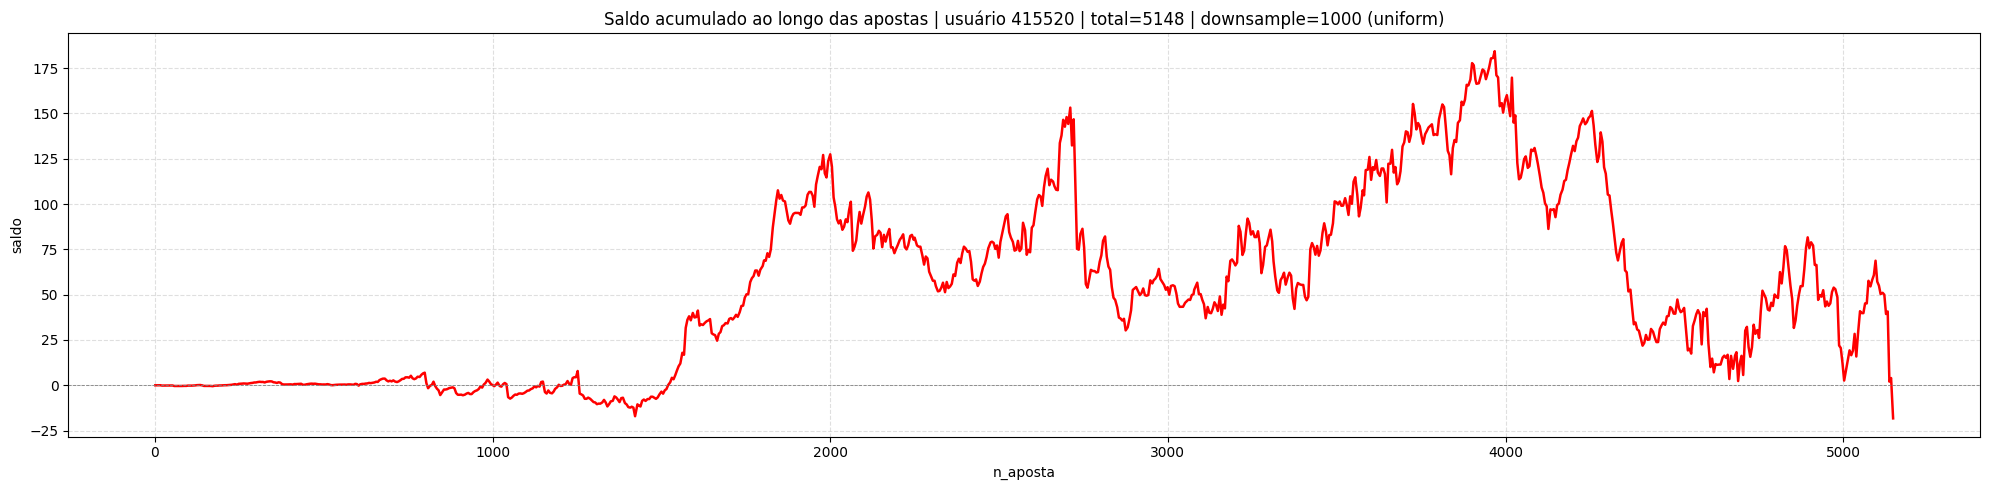

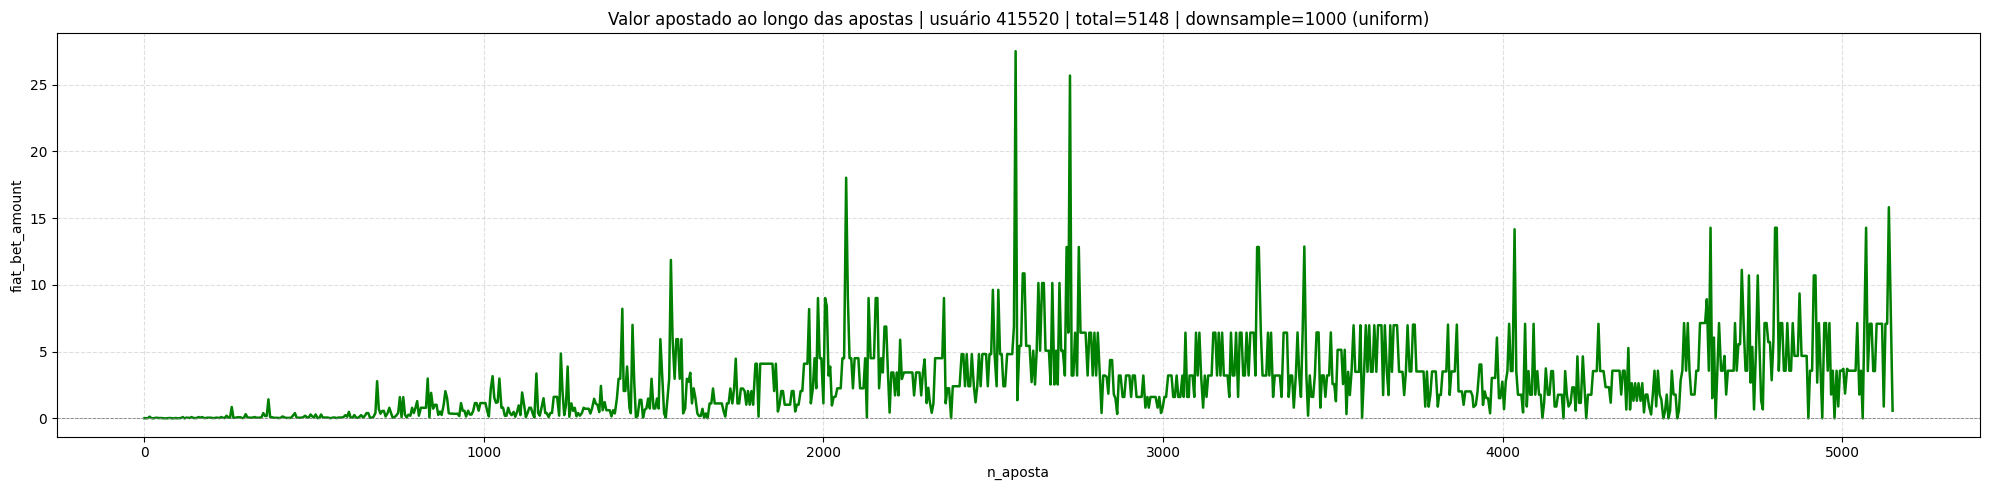

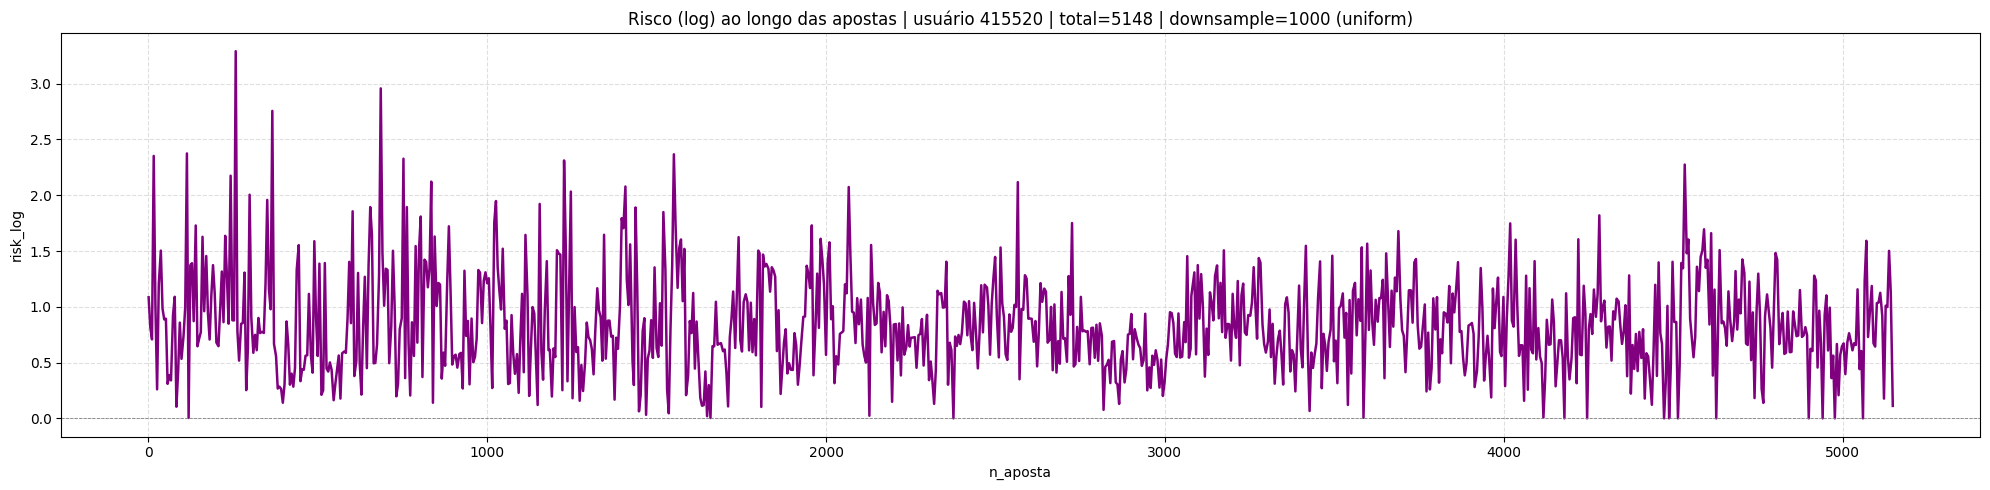

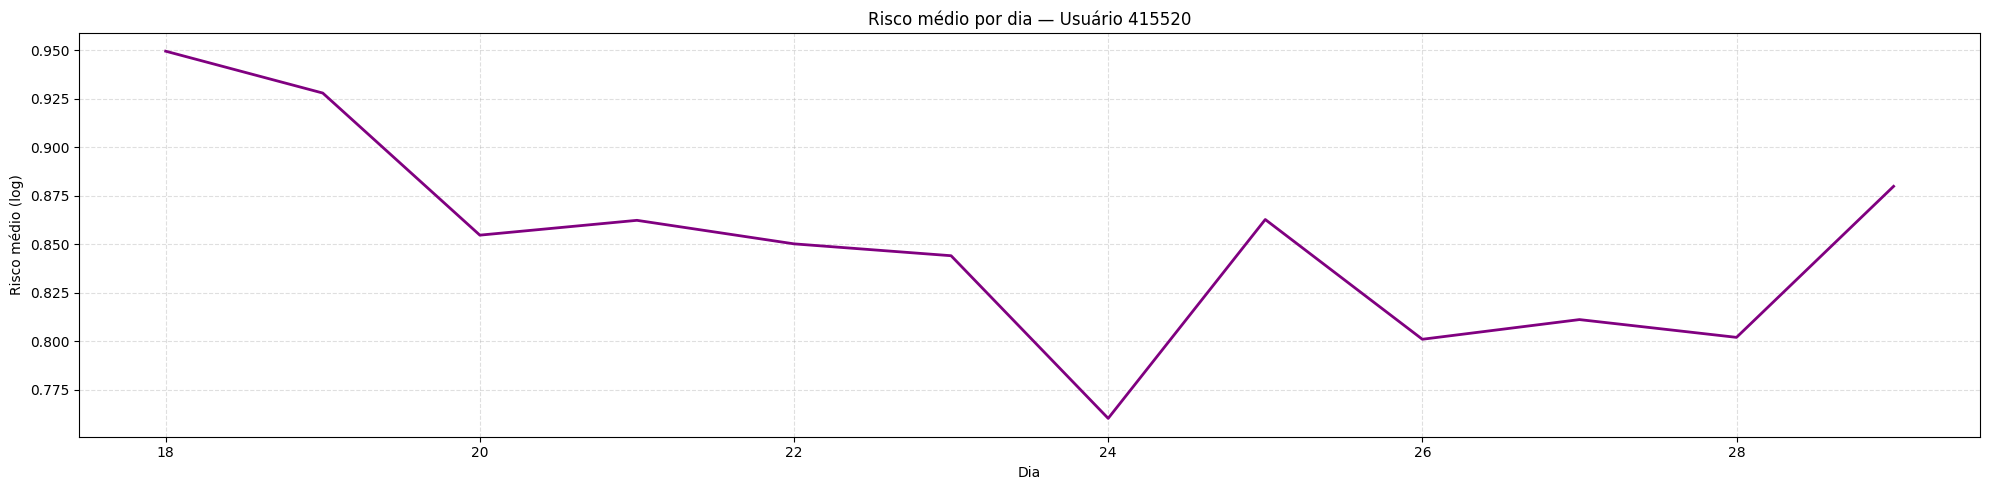

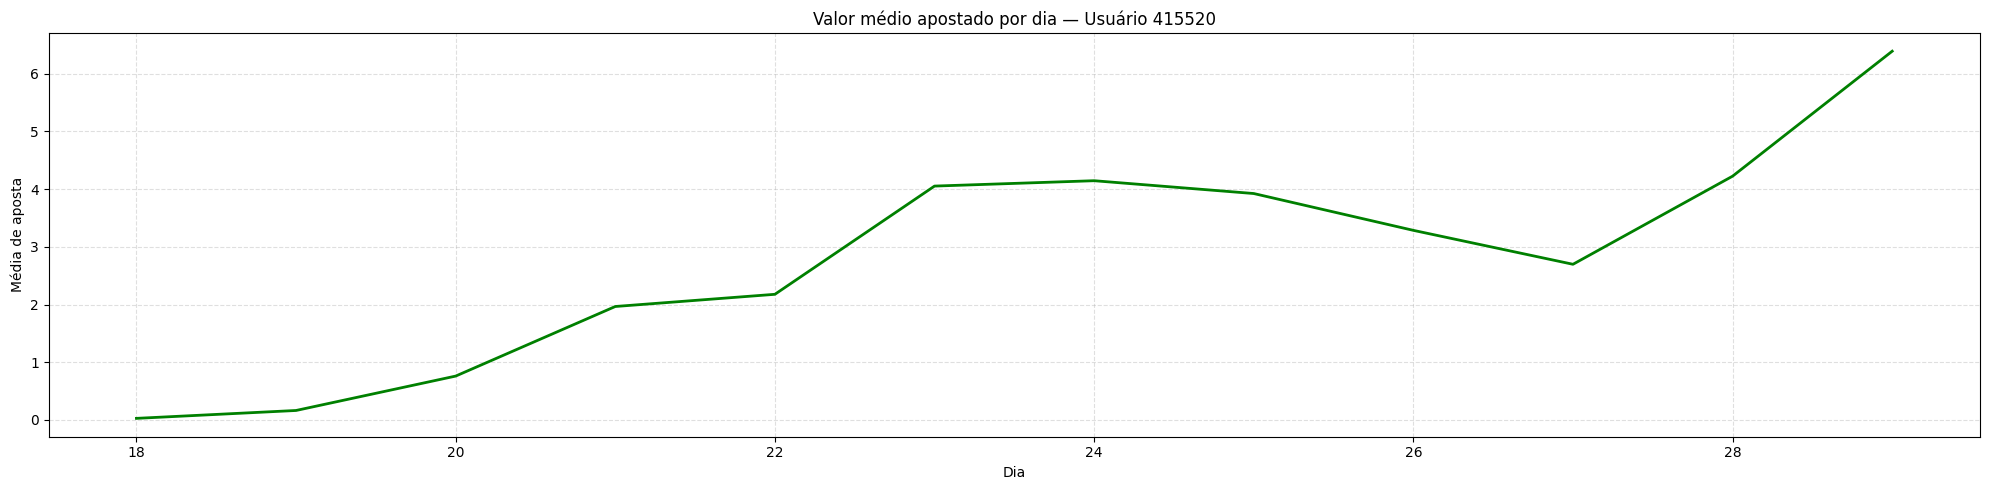

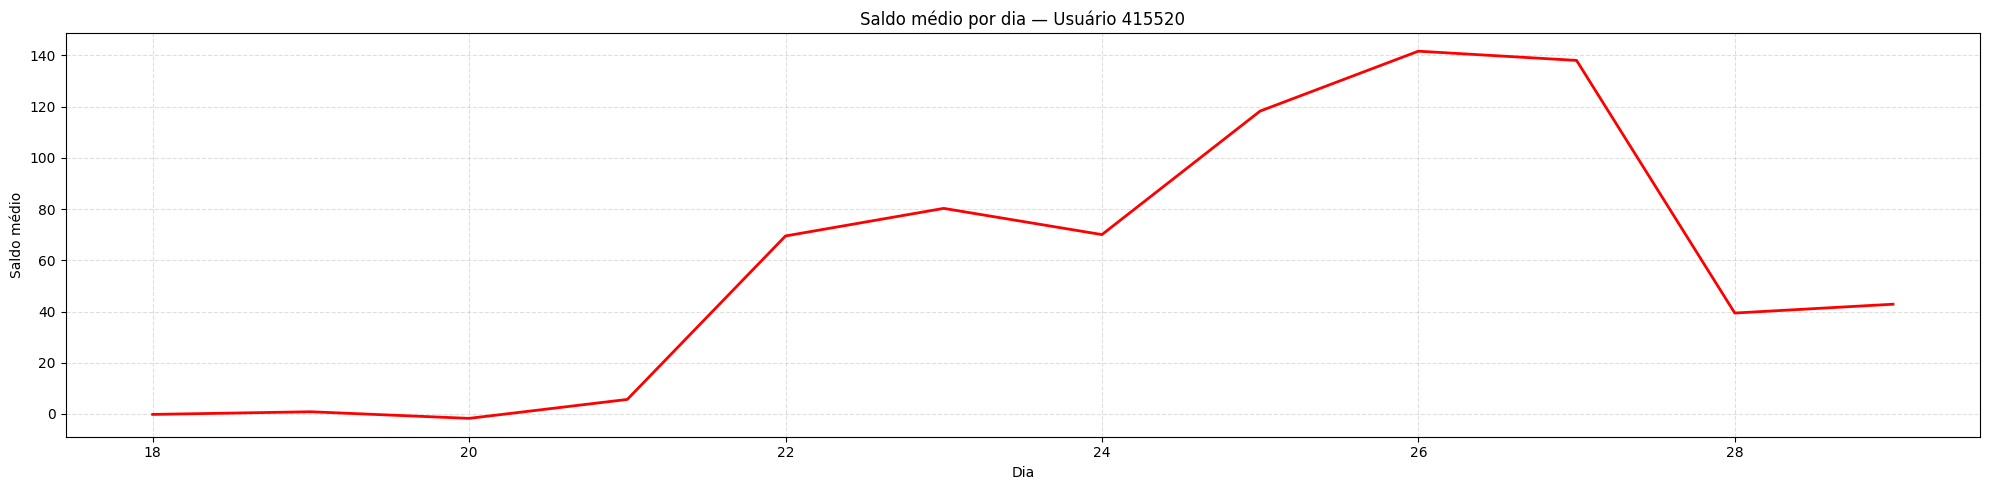

In [ ]:
plot_user_series(df_final, 415520, max_points=100, downsample_method="random_block", random_state=22)
plot_user_profile(df, 415520, max_points=1000)


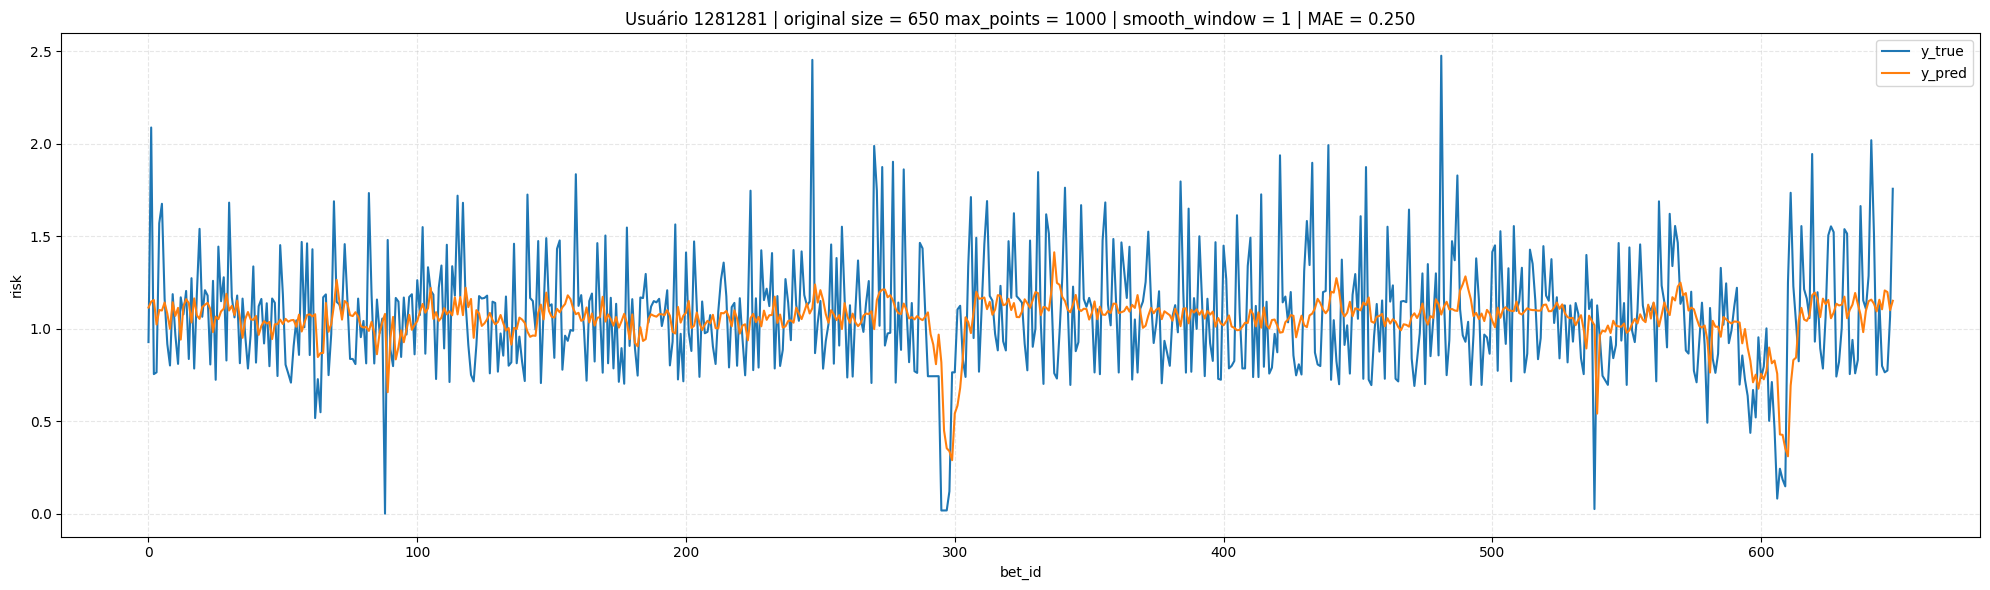

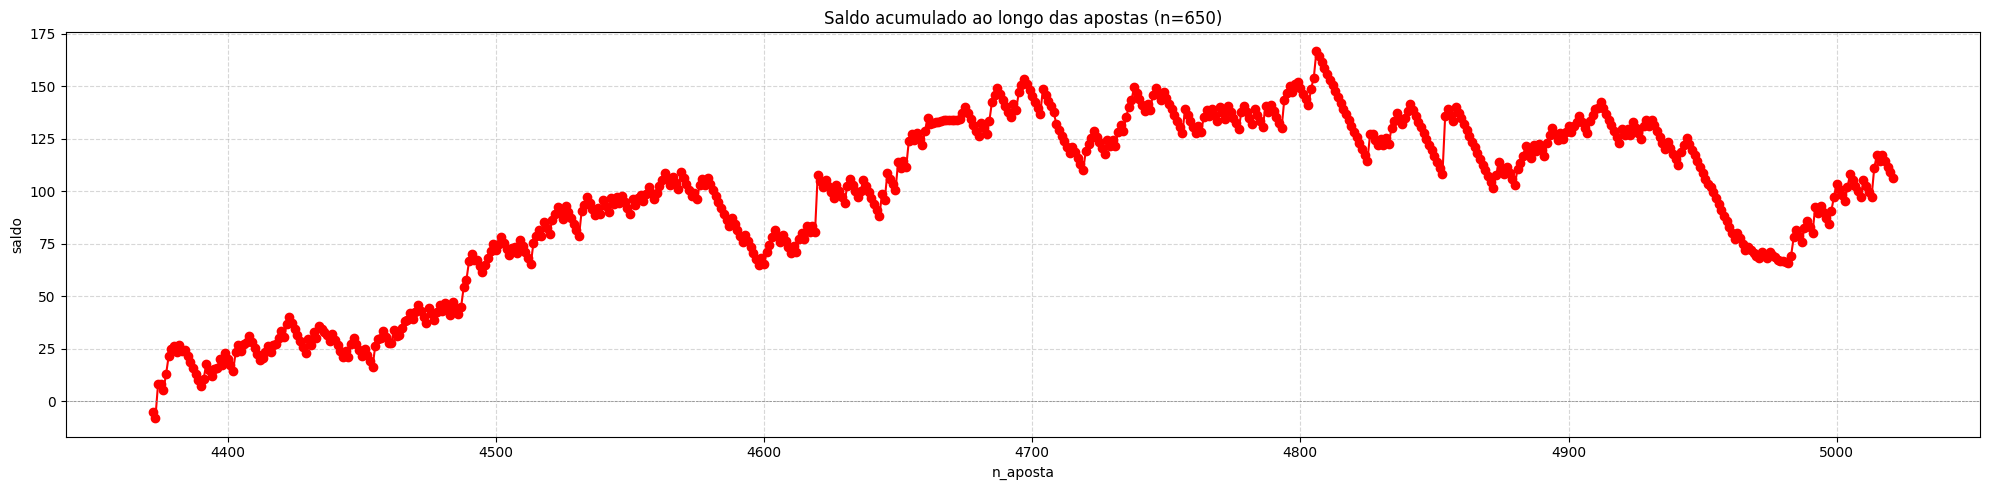

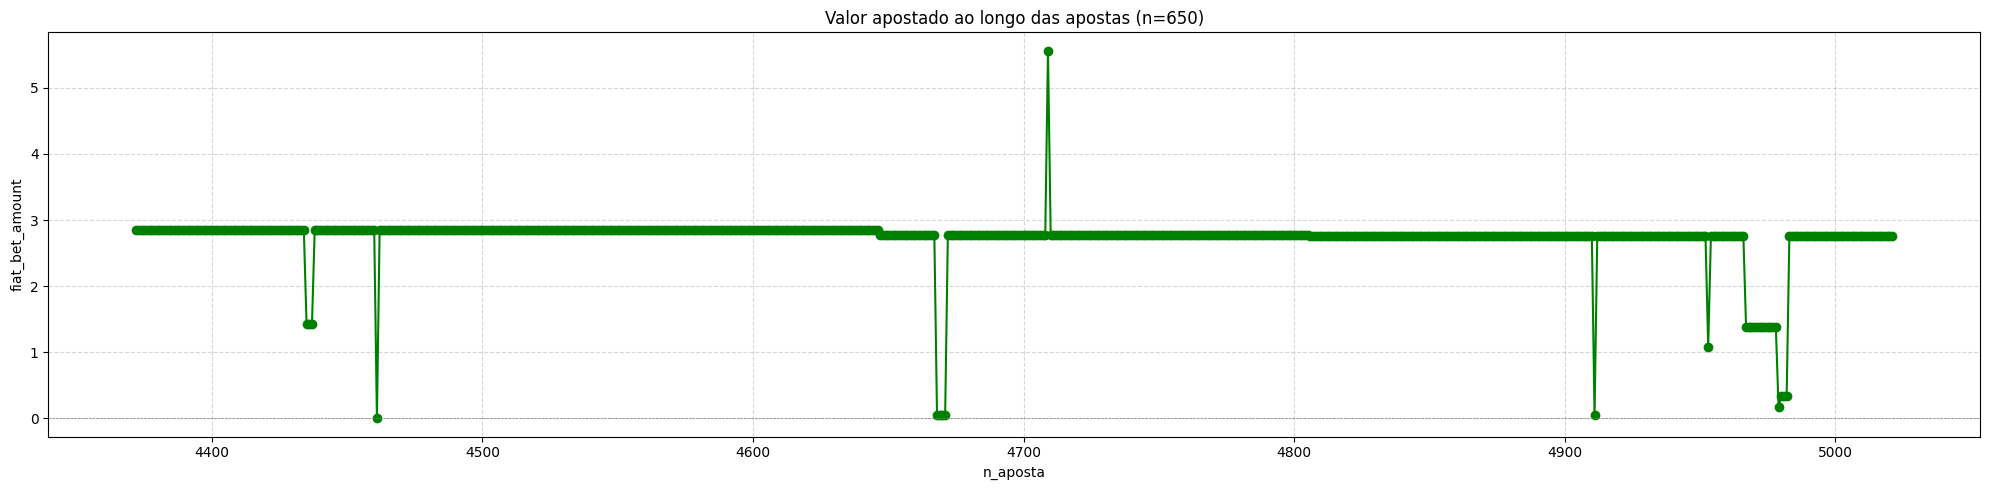

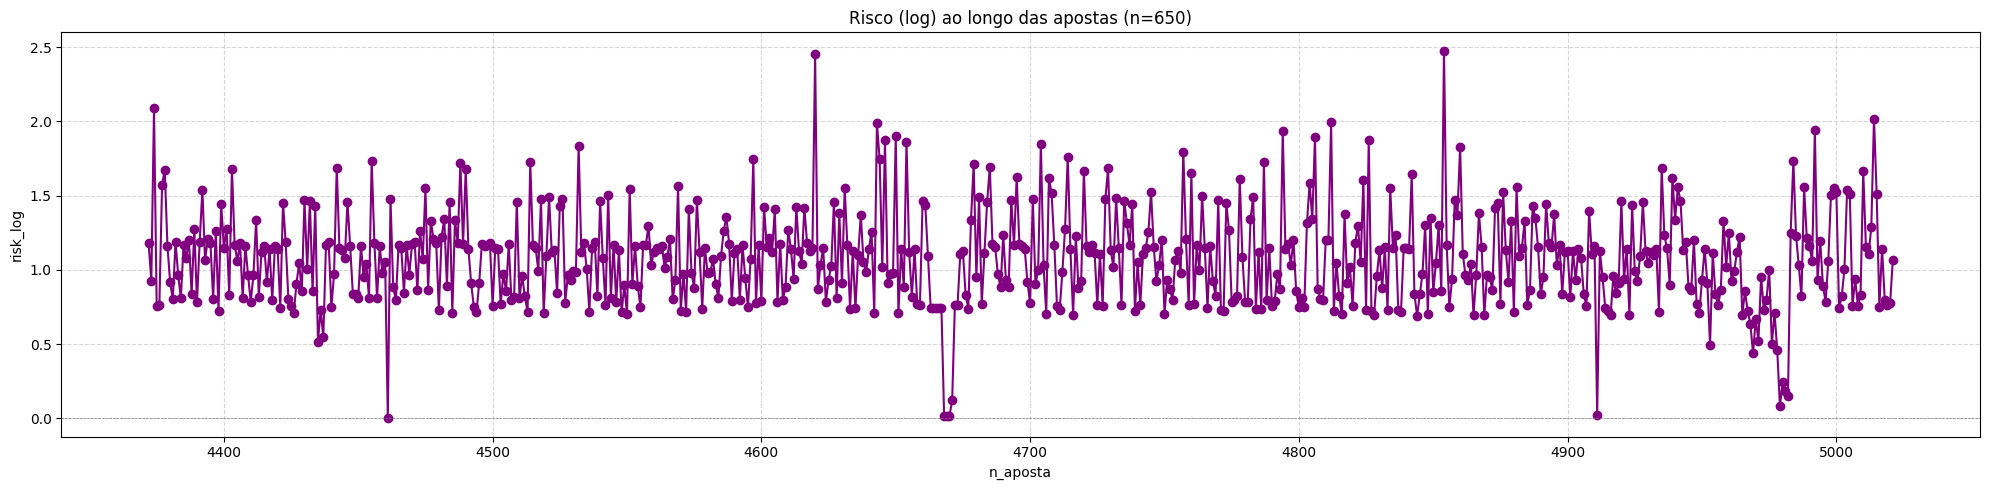

In [ ]:
uid = 1281281

size = len(meta_test[meta_test['user_id']==uid])

bets_list = meta_test[meta_test['user_id']==uid]['bet_id'].unique().tolist()

if len(bets_list) >= size:
    start_idx = random.randint(0, len(bets_list) - size)
    selected_bets = bets_list[start_idx:start_idx + size]
else:
    selected_bets = bets_list
    
plot_user_series(y_test, y_pred, meta_test, uid, selected_bets, max_points=1000, smooth_window=1)

user_bets = df[df['bet_id'].isin(selected_bets)]
plot_selected_bets(user_bets)


In [ ]:
# plot_user_series(y_test, y_pred, meta_test, uid, selected_bets, max_points=1000, smooth_window=1)
#plot_user_series_low(y_test, y_pred, meta_test, uid, selected_bets)
#0.430


In [ ]:
user_bets = df[df['bet_id'].isin(selected_bets)]
plot_selected_bets(user_bets)


game_id  user_id     bet_id  fiat_bet_amount  fiat_profit_amount  \
index                                                                        
18743280  2886962  1281281  232082542         2.842824            3.212391   
18743635  2886963  1281281  232082961         2.842824           -2.842824   
18743985  2886964  1281281  232083399         2.842824           16.232525   
18744712  2886966  1281281  232084219         2.842824            0.198998   
18746177  2886970  1281281  232085803         2.842824           -2.842824   
...           ...      ...        ...              ...                 ...   
23228698  2899698  1281281  236966054         2.758577            2.730991   
23231662  2899706  1281281  236969270         2.758577           -2.758577   
23232044  2899707  1281281  236969730         2.758577           -2.758577   
23233173  2899710  1281281  236970969         2.758577           -2.758577   
23233910  2899712  1281281  236971741         2.758577           -2.758577   

           timestamp       saldo  n_aposta  risk_log  \
index                                                  
18743280  1601092804   -5.343428      4372  1.178119   
18743635  1601092804   -8.186252      4373  0.928083   
18743985  1601092804    8.046273      4374  2.088738   
18744712  1601092804    8.245271      4375  0.754970   
18746177  1601092804    5.402447      4376  0.764540   
...              ...         ...       ...       ...   
23228698  1601438402  117.282669      5017  1.143819   
23231662  1601438402  114.524094      5018  0.799437   
23232044  1601438402  111.765518      5019  0.764660   
23233173  1601438402  109.006943      5020  0.774207   
23233910  1601438402  106.248367      5021  1.067266   

          global_avg_game_bet_amount  ...  risk_log_50_mean_games  \
index                                 ...                           
18743280                    0.246286  ...                1.131435   
18743635                    0.274470  ...                1.124296   
18743985                    0.379311  ...                1.144764   
18744712                    0.219358  ...                1.111353   
18746177                    0.260466  ...                1.111684   
...                              ...  ...                     ...   
23228698                    7.715288  ...                1.001774   
23231662                    7.378216  ...                1.005007   
23232044                    7.581308  ...                1.011558   
23233173                    7.889042  ...                1.013659   
23233910                    7.678234  ...                1.024593   

          risk_log_50_std_games  risk_log_50_median_games  \
index                                                       
18743280               0.360823                  1.065896   
18743635               0.361254                  1.060747   
18743985               0.385990                  1.061319   
18744712               0.342745                  1.046207   
18746177               0.342395                  1.046207   
...                         ...                       ...   
23228698               0.451454                  0.978215   
23231662               0.449368                  0.978215   
23232044               0.443267                  0.978215   
23233173               0.441858                  0.978215   
23233910               0.436135                  1.003041   

          risk_log_100_mean_games  risk_log_100_std_games  \
index                                                       
18743280                 1.113442                0.376585   
18743635                 1.115353                0.375138   
18743985                 1.128870                0.385575   
18744712                 1.128750                0.385691   
18746177                 1.128825                0.385619   
...                           ...                     ...   
23228698                 1.031244                0.369151   
23231662                 

In [ ]:
meta_test["user_id"].unique()


[1479496, 1479639, 1480113, 1481536, 1482280, ..., 363896, 1380934, 1183222, 1503516, 1503513]
Length: 11370
Categories (32102, uint32): [44, 46, 5588, 5977, ..., 1503513, 1503516, 1503542, 1503546]

In [ ]:
mae = pd.DataFrame({
    "user_id": meta_test["user_id"],
    "y_true": y_test,
    "y_pred": y_pred
})
mae["abs_error"] = (mae["y_true"] - mae["y_pred"]).abs()

user_stats = (
    mae.groupby("user_id", as_index=False)
      .agg(
          mae=("abs_error", "mean"),
          avg_risk=("y_true", "mean"),
          std_risk=("y_true", "std"),
          avg_pred=("y_pred", "mean"),
          n_bets=("y_true", "count")
      )
)
user_stats = user_stats.dropna()
user_stats.head()


C:\Users\mathe\AppData\Local\Temp\ipykernel_32676\3867553993.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae.groupby("user_id", as_index=False)


user_id       mae  avg_risk  std_risk  avg_pred  n_bets
0       44  0.041737  0.004770  0.006141  0.045564      13
2     5588  0.583176  1.029956  0.842232  0.994629    1238
3     5977  0.943433  2.528799  0.920115  2.046056      18
6     9699  0.127763  0.508598  0.650463  0.525836    1643
12   23074  0.450024  1.675823  0.514739  1.225799       2

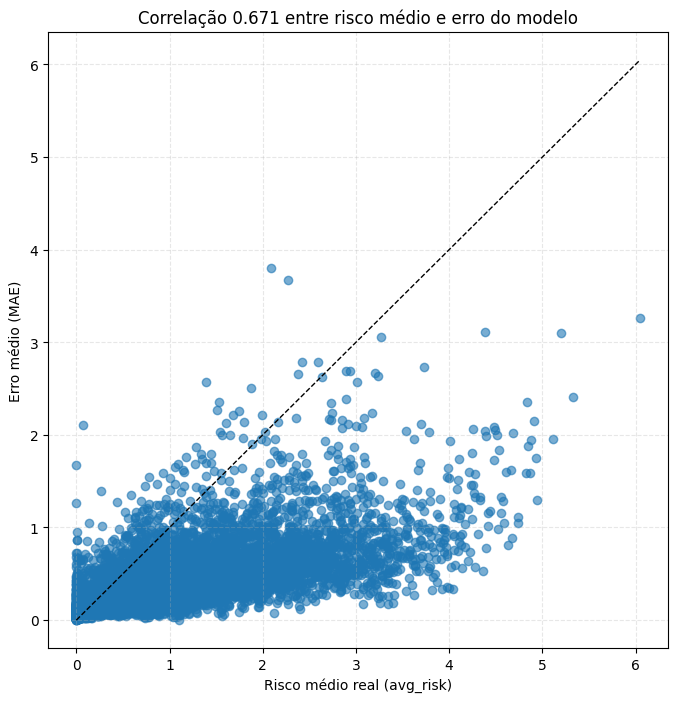

In [ ]:
corr = user_stats[["avg_risk", "mae"]].corr().iloc[0, 1]
plt.figure(figsize=(8, 8))
plt.scatter(user_stats["avg_risk"], user_stats["mae"], alpha=0.6)
plt.xlabel("Risco médio real (avg_risk)")
plt.ylabel("Erro médio (MAE)")
a = min(user_stats['avg_risk'].min(), user_stats['mae'].min())
b = max(user_stats['avg_risk'].max(), user_stats['mae'].max())
plt.plot([a, b], [a, b], 'k--', lw=1)

plt.title(f"Correlação {corr:.3f} entre risco médio e erro do modelo")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


In [ ]:
from pingouin import partial_corr
partial_corr(data=user_stats, x='avg_risk', y='mae', covar='std_risk')



n       r         CI95%  p-val
pearson  10796  0.4768  [0.46, 0.49]    0.0

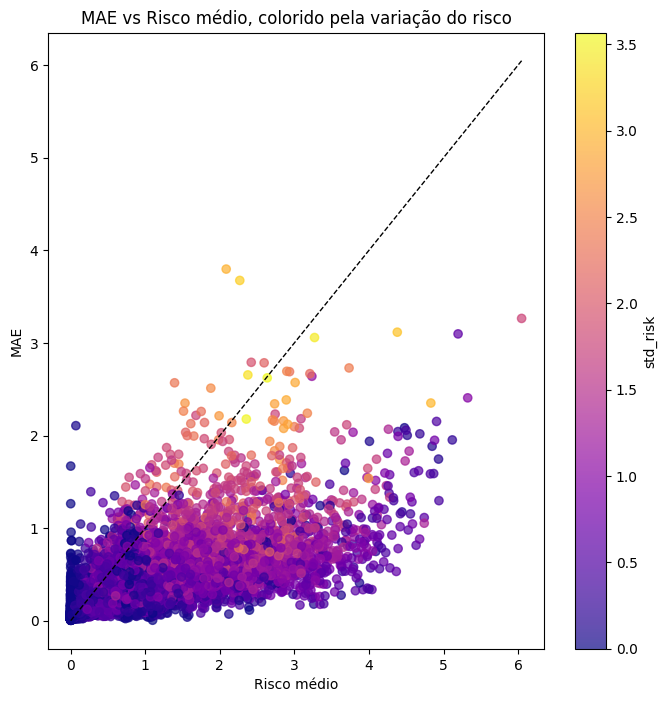

In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(user_stats['avg_risk'], user_stats['mae'],
            c=user_stats['std_risk'], cmap='plasma', alpha=0.7)
a = min(user_stats['avg_risk'].min(), user_stats['mae'].min())
b = max(user_stats['avg_risk'].max(), user_stats['mae'].max())
plt.plot([a, b], [a, b], 'k--', lw=1)
plt.colorbar(label='std_risk')
plt.xlabel('Risco médio')
plt.ylabel('MAE')
plt.title('MAE vs Risco médio, colorido pela variação do risco')
plt.show()
